In [1]:
import os
import json
from tqdm import tqdm
import requests
from collections import Counter
import seaborn as sns
import pandas as pd
import dataframe_image as dfi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date, datetime as dt
import time,datetime
import re
import unicodedata
import ast  # Module to handle literal_eval function

In [2]:
from upsetplot import generate_counts
from upsetplot import plot
from upsetplot import from_memberships
from upsetplot import UpSet
from matplotlib import pyplot
from itertools import combinations

In [23]:
# Targeting the retraction_index_path
retraction_index_path = os.path.abspath('../../retractionIndex/STI2023_revisit/')
retraction_index_path

data_dir = retraction_index_path+'/dataset/' # data directory
result_dir = retraction_index_path +'/result/'


#### Configuration File

In [249]:
# Load configuration
con_file = open(retraction_index_path+"/config.json")
config = json.load(con_file)
con_file.close()

# Initializing variable for configuration file
my_email = config['my_email']
elsevier_api_key = config['Elsevier_APIKEY']
elsevier_insttoken = config['insttoken']
ieee_xplore_api_key = config['IEEEXplore_APIKEY']
wos_api_key = config['WoS_APIKEY']

In [251]:
# Global initializatiion
global my_email
global elsevier_api_key
global elsevier_insttoken
global ieee_xplore_api_key
global wos_api_key

In [28]:
os.listdir(data_dir)

['crossref_retractedpublication_2024-07-03.csv',
 'retractionwatch_2024-07-03.csv',
 'scopus_retractedpublication_2024-07-05.csv',
 'webofsciencecore_retractedpublication_2024-07-03.csv']

### Creating Present Union list As At July2024

In [30]:
"""
Input the date you retrieve retraction publications for each database

#Update the date for each database format: YYYY-MM-DD e.g. 2024-02-13
"""


getdate = {'scopus': '2024-07-05',
            'crossref':'2024-07-03',
            'retractionwatch': '2024-07-03',
            'webofsciencecore': '2024-07-03'} 


In [36]:
def convert_unicode(string: str) -> str:
    """
    It takes a string and passes it through different encoding parameter phases
    E.g. '10.\u200b1105/\u200btpc.\u200b010357' ->  '10.1105/tpc.010357'
    
    :param string: variable to be encoded
    :return: the actual string value devoided of encoded character
    """
    
    string = unicodedata.normalize('NFKD', string).encode('iso-8859-1', 'ignore').decode('iso-8859-1')
    string = unicodedata.normalize('NFKD', string).encode('latin1', 'ignore').decode('latin1')
    string = unicodedata.normalize('NFKD', string).encode('cp1252', 'ignore').decode('cp1252')
    return string

In [449]:
"""
- Reading in Crossref file and renaming some columns
"""
crossref = pd.read_csv(data_dir+'crossref/crossref_retractedpublication_'+\
                     getdate['crossref']+'.csv').drop('Unnamed: 0',axis=1)
crossref['source'] = 'Crossref'

crossref['DOI']= crossref['DOI'].str.lower().str.strip().astype(str).apply(convert_unicode)
crossref.head(2)

,DOI,Year,URL,Title,Author,Journal,Doc_type,source
0,10.1007/s11665-016-1940-8,2016,http://dx.doi.org/10.1007/s11665-016-1940-8,RETRACTED ARTICLE: Multi-Length Scale Analysis...,"[{'given': 'M.', 'family': 'Grujicic', 'sequen...",Journal of Materials Engineering and Performance,Retraction,Crossref
1,10.1177/0267659115588021,2015,http://dx.doi.org/10.1177/0267659115588021,Retraction notice,NaN,Perfusion,Retraction,Crossref


In [37]:
"""
- Reading in Retraction Watch items
"""

retractionwatch = pd.read_csv(data_dir+'/retractionwatch/retractionwatch_'+\
                     getdate['retractionwatch']+'.csv', encoding='latin1').rename(
    columns={'OriginalPaperDOI':'DOI', 
             'OriginalPaperPubMedID': 'PubMedID', 
             'OriginalPaperDate': 'Year'})

retractionwatch['source']='Retraction Watch'


retractionwatch['PubMedID']= retractionwatch['PubMedID'].fillna(0).astype(int)\
                .replace(0,'').astype(str).str.strip()

retractionwatch['RetractionPubMedID']= retractionwatch['RetractionPubMedID'].fillna(0).astype(int)\
                .replace(0,'').astype(str)

#rerun 
retractionwatch['Year']=  pd.to_datetime(retractionwatch['Year']).dt.year
retractionwatch['RetractionYear']=  pd.to_datetime(retractionwatch['RetractionDate']).dt.strftime("%Y").fillna(0).astype(int)
#pd.to_datetime(retractionwatch['Year']).dt.year

# A row in retraction Watch contains '|' from a row in 
retractionwatch['DOI']= retractionwatch['DOI'].str.replace(r'\|', '') # "10.1038/embor.2009.88 |"

retractionwatch['DOI'] = retractionwatch['DOI'].str.lower().fillna('').str.strip().apply(convert_unicode)

retractionwatch.head()

/var/folders/yk/fnf1_8ns45l37dy9skp83h5r0000gn/T/ipykernel_34111/3505987413.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  retractionwatch['DOI']= retractionwatch['DOI'].str.replace(r'\|', '') # "10.1038/embor.2009.88 |"


,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,...,RetractionPubMedID,Year,DOI,PubMedID,RetractionNature,Reason,Paywalled,Notes,source,RetractionYear
0,54381,Pluripotency of mesenchymal stem cells derived...,(BLS) Biology - Cellular;,"Stem Cell Institute, University of Minnesota M...",Nature,Springer - Nature Publishing Group,United States,Yuehua Jiang;Balkrishna N Jahagirdar;R Lee Rei...,https://retractionwatch.com/2024/06/18/nature-...,Research Article;,...,12077603,2002,10.1038/nature00870,12077603,Correction,+Concerns/Issues About Image;+Error in Text;+U...,No,see also: https://pubpeer.com/publications/DF9...,Retraction Watch,2007
1,54378,Addressing the financial empowerment needs of ...,(B/T) Business - Economics;(HSC) Medicine - Ne...,"The University Of Manitoba, Winnipeg, Canada; ...",Brain Injury,Taylor and Francis,Canada,Lisa Engel;Roheema Ewesesan;Ibiyemi Arowolo;Ka...,NaN,Conference Abstract/Paper;,...,,2023,10.1080/02699052.2023.2194723,,Retraction,+Duplicate Publication through Error by Journa...,No,NaN,Retraction Watch,2023
2,54374,Regulation Mechanism of Spatial Capacity of To...,(B/T) Data Science;(B/T) Technology;(SOC) Spor...,"School of Henan College of Transportation, Zhe...",Complexity,Hindawi,China,Xiaona Xie;Wenliang Zhang,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,...,,2021,10.1155/2021/3934894,,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,NaN,Retraction Watch,2024
3,54373,An Investigation in Applying Internet of Thing...,(B/T) Data Science;(HSC) Medicine - Diabetes;(...,"Department of IT, VR Siddhartha Engineering Co...",Journal of Food Quality,Hindawi,Afghanistan;India,G Geetha;R Radeep Krishna;Swati Vyas;Isha Sukh...,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,...,,2022,10.1155/2022/4281237,,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,NaN,Retraction Watch,2024
4,54363,Smiling and laughing in patients with Prolonge...,(HSC) Medicine - Neurology;(HSC) Medicine - Re...,"National Rehabilitation Hospital, Dublin, Dun ...",Brain Injury,Taylor and Francis,Ireland,Catriona Moran;Alison McCann,NaN,Conference Abstract/Paper;,...,,2023,10.1080/02699052.2023.2194723,,Retraction,+Duplicate Publication through Error by Journa...,No,NaN,Retraction Watch,2023


In [38]:
"""
- Reading in Scopus file and renaming some columns
"""
scopus = pd.read_csv(data_dir+'scopus/scopus_retractedpublication_'+\
                     getdate['scopus']+'.csv').rename(
    columns={'Authors':'Author',
             'Source':'source',
             'Titles':'Title',
             'Source title':'Journal',
             'PubMed ID': 'PubMedID'})



# Converting 'Publication_date' to Date to extract the year
scopus['Publication_date'] = pd.to_datetime(scopus['Publication_date'])
scopus['Year'] = scopus['Publication_date'].dt.year
#scopus['Year'] = pd.to_numeric(scopus['Year']).fillna(0).astype(int)

scopus['DOI']= scopus['DOI'].str.lower().str.strip().astype(str).apply(convert_unicode)

scopus['PubMedID']= scopus['PubMedID'].fillna(0).astype(int)\
                .replace(0,'').astype(str).str.strip()

scopus['source'] = 'Scopus'

scopus.head(2)

,DOI,Eid,Title,Publication_date,Author,Affiliations,Journal,PubMedID,Pub_type,Pub_type2,Year,source
0,10.1038/s41467-024-46890-9,2-s2.0-85188642170,Metal free cross-dehydrogenative N-N coupling ...,2024-12-01,"['Kathiravan S.,Dhillon P.,Zhang T.,Nicholls I...","[{'@_fa': 'true', 'affiliation-url': 'https://...",Nature Communications,38531886,Journal,Retracted,2024,Scopus
1,10.1186/s13635-024-00152-9,2-s2.0-85185843184,Network security threat detection technology b...,2024-12-01,['Lan Z.'],"[{'@_fa': 'true', 'affiliation-url': 'https://...",Eurasip Journal on Information Security,,Journal,Retracted,2024,Scopus


In [44]:
"""
Loading in indexed retracted publications from Web of Science Core
"""

webofsciencecore= pd.read_csv(data_dir+f'webofscience/webofsciencecore_retractedpublication_'+\
                     getdate['webofsciencecore']+'.csv')

webofsciencecore['source'] = 'WoS_Core'

webofsciencecore['DOI']= webofsciencecore['DOI'].str.lower().str.strip().astype(str).apply(convert_unicode)

# Remove decimal part
webofsciencecore['PubMedID'] = webofsciencecore['PubMedID'].fillna('').astype(str).str.split('.').str[0]



webofsciencecore.head(2)

,DOI,Uid,Title,Year,Month,Authors,Journal,Pub_type,PubMedID,source
0,nan,WOS:000188338800028,The trend-seasonal normal in time series (Retr...,1926,NaN,"{'authors': [{'displayName': 'Whelden, CH Jr',...",JOURNAL OF THE AMERICAN STATISTICAL ASSOCIATION,"['Article', 'Retracted Publication']",,WoS_Core
1,10.1007/bf01488952,WOS:000200264000131,Natural science and real outside world (Retrac...,1940,NaN,"{'authors': [{'displayName': 'Planck, M', 'wos...",NATURWISSENSCHAFTEN,"['Article', 'Retracted Publication']",,WoS_Core


In [46]:
def checkindividualdataset(x):
    
    # Input dataframe names as x
    
    '''
    Clean and deplicate records based on DOIs.
    After removing duplicates, we will return the count and the list of records with DOI, 
    those without DOIs and duplicated records that will be dropped.
    '''
    
    # Fixing '0.1080/20430795.2021.1894544' DOI error instead of '10.1080/20430795.2021.1894544', 
    # a perculiar Retraction Watch
    
    # Getting the DataFrame name
    df_name = [name for name, obj in globals().items() if obj is x][0]

    if df_name == 'retractionwatch':
            if '10.1038/embor.2009.88 |' in x['DOI'].tolist():
                x['DOI'] = x['DOI'].replace('10.1038/embor.2009.88 |', '10.1038/embor.2009.88')

#             if '0.1080/20430795.2021.1894544' in x['DOI'].tolist():
#                 x['DOI'] = x['DOI'].replace('10.7705/biomedica.v38i0.3546)', '10.7705/biomedica.v38i0.3546')


    
    # Step 1: We identify the unique records of each dataset based on DOI.
    # 'records_withDOI_hasdup': Identify records that have a valid DOI which should start with '10.'
    # 'records_withDOI': Drop the duplicates from the previous line.
    
    records_withDOI_hasdup= x.loc[x['DOI'].str.startswith('10.', na=False)]
    
    if df_name == 'pubmed':
        records_withDOI = records_withDOI_hasdup.drop_duplicates(subset=['DOI'], keep='last')
    else:
        records_withDOI = records_withDOI_hasdup.drop_duplicates(subset=['DOI'], keep='first')

    
    # Step 2: We create two duplicate lists.
    # 'duplicated_records_all': Identify ALL duplicated records for reference and download for checking manually.
    # 'duplicated_records': Identify duplicated records to drop but keep only the first occurrence of each group of duplicates.
    duplicate_records_all = records_withDOI_hasdup.loc[records_withDOI_hasdup.duplicated(subset=['DOI'],keep=False), :]
    
    
    # To check anamolies - to remove record with PubMedID 28202934 and leave that 26511294 with correct date
    if df_name == 'pubmed':
        duplicate_records = records_withDOI_hasdup.loc[records_withDOI_hasdup.duplicated(subset=['DOI'],keep='last'), :]
    else:
        duplicate_records = records_withDOI_hasdup.loc[records_withDOI_hasdup.duplicated(subset=['DOI'],keep='first'), :]


    
    # Step 3: We get the count of records without DOI. Duplicates may exist since we could not use DOI to identify duplicate records
    records_withoutDOI = x.loc[~x['DOI'].str.startswith('10.', na=False)]    

    
    try:
        
        if len(x) == len(records_withDOI)+len(records_withoutDOI)+len(duplicate_records):
            return[len(x), len(records_withDOI),len(records_withoutDOI),len(duplicate_records), records_withDOI, records_withoutDOI, duplicate_records, duplicate_records_all]
            # return the count and items of each group
    
    except: 
        return('ERROR')

In [47]:
def count_DOI_n_PubMedID(df, source)-> list:
    """
    :param df: DataFrame to work on
    :param source: source to lookup to determine number of count
    
    :return: source, # DOI, # PubMedID, # Duplicated record -> list
    
    """
    
    
    df_DOI= df[(df['DOI'].str.startswith('10')) & (df['source'].str.contains(source))]
    
    df_nodupDOI= df_DOI.drop_duplicates(subset=['DOI'], keep='first') # DF that has no duplicated DOI
    
    df_duplicatedDOI= df_DOI[df_DOI.duplicated(subset=['DOI'],keep='last')] # DF that are duplicated
    
    
    df_noDOI= df[~(df['DOI'].str.startswith('10')) & (df['source'].str.contains(source))] # DF that has no DOI
    
    
    nDOI= len(df_nodupDOI) # Numbers of items with unique DOI
    nDuplicatedDOI= len(df_duplicatedDOI) # Numbers of items that has duplicated DOI removed
    nNoDOI= len(df_noDOI) # Numbers of items with without DOI
    
    
    
    if 'PubMedID' in df.columns:
        
        df_PMID= df_DOI[((df_DOI['PubMedID'] != "") | df_DOI['PubMedID'].isna()) & (df_DOI['source'].str.contains(source))]
        
        df_nodupPMID= df_PMID.drop_duplicates(subset=['DOI'], keep='first') # DF that has no duplicated PMID
        
        df_duplicatedPMID= df_PMID[df_PMID.duplicated(subset=['DOI'],keep='last')] # DF that are duplicated
        
        df_noPMID= df[~(((df['PubMedID'] != "") | df['PubMedID'].isna()) & (df['source'].str.contains(source)))]
        
        
        nPMID= len(df_nodupPMID) # Numbers of items with unique PMID
        nDuplicatedPMID= len(df_duplicatedPMID)  # Numbers of items that has duplicated PMID
        nNoPMID= len(df_noPMID)  # Numbers of items with without PMID
        
    else:
        nPMID,nDuplicatedPMID,nNoPMID= 0,0,0
        
        
    Total= len(df)
        
    return  source,Total, nDOI,nNoDOI,nDuplicatedDOI,nPMID,nNoPMID,nDuplicatedPMID #nDuplicateDOI,nPubMedID,nDuplicatePubMedID

In [48]:
"""
Counting # DOIs, PubMedID
#  return: source,Total, nDOI,nNoDOI,nDuplicatedDOI,nPMID,nNoPMID,nDuplicatedPMID 
"""
nCrossref= count_DOI_n_PubMedID(crossref,'Crossref')
nRW= count_DOI_n_PubMedID(retractionwatch,'Retraction Watch')
nScopus= count_DOI_n_PubMedID(scopus,'Scopus')
nWoS=count_DOI_n_PubMedID(webofsciencecore,'WoS_Core')

In [52]:
"""
Aggregate the items from all the sources
"""
dbtable = [] # A nested list which stores the records of each group in each source
ovtable = [] # Store the count of each group from each source and create a table for viewing

dblist= [nCrossref, nRW, nScopus, nWoS]

#uery results retrieved	Records with DOI	Records without DOI removed	Duplicate records removed
# source,Total, nDOI,nNoDOI,nDuplicatedDOI,nPMID,nNoPMID,nDuplicatedPMID
for result in dblist:
    dbtable.append(result)
    
    np_results= np.array(dbtable)
    
# Create a table showing the count of each group
overview = pd.DataFrame(np_results[:,[1,2,3,4,5]])
overview.columns =['Query_result', 'Records_withDOI', 'Records_withoutDOI', 'Duplicate_DOI_removed', 'DOI_records_withPubMedID']
overview['source']= ['Crossref','Retraction Watch','Scopus','Web of Science Core']


# overview.loc[len(overview)] = [overview.Query_result.sum(), overview.Records_withDOI.sum(), overview.Duplicate_DOI_removed.sum(), overview.DOI_records_withPubMedID.sum(),''] 


# Re-order column
overview = overview[['source', 'Query_result', 'Records_withDOI', 'Records_withoutDOI', 'Duplicate_DOI_removed', 'DOI_records_withPubMedID']]



# overview.insert(0, 'source', overview.pop('source'))
# overview['source'][11]= 'Total'

# Aggregating items in each column
overview.loc[len(overview)] = ['Total',overview.Query_result.astype(int).sum(), overview.Records_withDOI.astype(int).sum(),
                               overview.Records_withoutDOI.astype(int).sum(), 
                               overview.Duplicate_DOI_removed.astype(int).sum(), overview.DOI_records_withPubMedID.astype(int).sum(),] 



overview\
#         .to_csv(result_dir+'datasources_overview_unionlist_crws.csv')

,source,Query_result,Records_withDOI,Records_withoutDOI,Duplicate_DOI_removed,DOI_records_withPubMedID
0,Crossref,30921,30918,0,3,0
1,Retraction Watch,53800,45419,5922,2459,21664
2,Scopus,31268,30878,338,52,8750
3,Web of Science Core,32772,31683,1062,27,20245
4,Total,148761,138898,7322,2541,50659


###### Exporting Records to Folder
- These include DOIs, deduplicated DOIs, and No DOI records

In [54]:
def export_datasets_from_sources(source_list: list, dbtable: list):
    """
    This function filter records with records with doi,without doi, and those with duplicated doi
    for each source and save each file
    
    :param source_list: list of dataframe of sources. This is dblist. It is initiated later
    :return: It will for each sources their: 
            - records with doi (saved as in this format: 'source_name_recordswithdoi_date')
            - records without doi (saved as in this format: 'source_name_recordsnodoi_date')
            - duplicated doi records (saved as in this format: 'source_name_duplicatedrecords_date')
    """
    
    
    for i in range(len(source_list[:-1])):
        source_name = [name for name, obj in globals().items() if obj is source_list[i]][0]
#         if source_name== 'wos_core':
#             source_name= 'webofsciencecore'
#         print(source_name)

        date = getdate[source_name]
        
        print(f'{source_name} was last updated on {date}')
        
        if source_name in ['webofsciencecore']:
            dbtable[i][4].sort_values(by=['DOI'], ascending=False).to_csv(data_dir+ 'webofscience'+'/'+source_name+'_recordswithdoi_'+date + '.csv')
            dbtable[i][5].to_csv(data_dir+ 'webofscience'+'/'+source_name+'_recordsnodoi_' + date + '.csv')
            dbtable[i][6].sort_values(by=['DOI'], ascending=False).to_csv(data_dir+ 'webofscience'+'/'+source_name+ '_duplicatedrecords_' + date + '.csv')

      
        else:
            dbtable[i][4].sort_values(by=['DOI'], ascending=False).to_csv(data_dir+ source_name+'/'+source_name+'_recordswithdoi_'+date + '.csv')
            dbtable[i][5].to_csv(data_dir+ source_name+'/'+source_name+'_recordsnodoi_' + date + '.csv')
            dbtable[i][6].sort_values(by=['DOI'], ascending=False).to_csv(data_dir+ source_name+'/'+source_name+ '_duplicatedrecords_' + date + '.csv')


      

In [71]:
# Saving records of items with DOIs, without DOIs, and duplicated records in each of the sources


dbtable2 = [] # A nested list which stores the records of each group in each source
dblist2 = [crossref,retractionwatch, scopus, webofsciencecore,'']

for x in dblist2[:-1]:
    dbtable2.append(checkindividualdataset(x))

export_datasets_from_sources(dblist2[:], dbtable2) # [-1] is to exclude '' in dblist2

crossref was last updated on 2024-07-03
retractionwatch was last updated on 2024-07-03
scopus was last updated on 2024-07-05
webofsciencecore was last updated on 2024-07-03


In [74]:
"""
Getting Records without DOI
"""
for rec in dbtable:
    src =rec[0]
    if rec[0]=='WoS_Core':
        src ='Web of Science'
    print(f"The total # records without DOI in {src} is {rec[3]}")

The total # records without DOI in Crossref is 0
The total # records without DOI in Retraction Watch is 5922
The total # records without DOI in Scopus is 338
The total # records without DOI in Web of Science is 1062


In [369]:
"""
Loading records lacking DOIs
"""

#nodoi_crossref_df= pd.read_csv(data_dir+'crossref/crossref_recordsnodoi_'+ getdate['crossref'] + '.csv')
nodoi_scopus_df= pd.read_csv(data_dir+'scopus/scopus_recordsnodoi_'+ getdate['scopus'] + '.csv')
nodoi_rw_df= pd.read_csv(data_dir+'retractionwatch/retractionwatch_recordsnodoi_'+ getdate['webofsciencecore'] + '.csv')
nodoi_wos_df= pd.read_csv(data_dir+'webofscience/webofsciencecore_recordsnodoi_'+ getdate['webofsciencecore'] + '.csv')

In [395]:
"""
Calculating Records with PMIDs lacking DOIs in the newly-added records

pmid_nodoi_srw  <- is the PMIDs of records that lack DOIs in union list CRWS
sti_nodoi_pmids_filtered <- is the PMIDs of records that lack DOIs in STI2023 union list 
"""

nodoi_scopus_df['PubMedID']= nodoi_scopus_df['PubMedID'].fillna(0).astype(int).astype(str)
nodoi_rw_df['PubMedID']= nodoi_rw_df['PubMedID'].fillna(0).astype(int).astype(str)
nodoi_wos_df['PubMedID']= nodoi_wos_df['PubMedID'].fillna(0).astype(int).astype(str)


# nodoi_wos_df[nodoi_wos_df['PubMedID']!='0']

pmid_nodoi_srw =set(nodoi_scopus_df[nodoi_scopus_df['PubMedID']!='0']['PubMedID'].tolist()+\
                    nodoi_rw_df[nodoi_rw_df['PubMedID']!='0']['PubMedID'].tolist() +\
                    nodoi_wos_df[nodoi_wos_df['PubMedID']!='0']['PubMedID'].tolist())


# 
print(f"The total # PMIDs of records lacking DOIs is {len(pmid_nodoi_srw)} in the union list ")

print(f"Newly-added-PMID Records with no DOI is {len(pmid_nodoi_srw - sti_nodoi_pmids_filtered)} \
between May 2023 to July 2024")

The total # PMIDs of records lacking DOIs is 1293 in the union list 
Newly-added-PMID Records with no DOI is 641 between May 2023 to July 2024


In [340]:
data_dir+'crossref/crossref_recordsnodoi_'+ getdate['crossref'] + '.csv'

'/Users/malikslam/Downloads/retractionIndex/STI2023_revisit/dataset/crossref/crossref_recordsnodoi_2024-07-03.csv'

In [391]:
"""
Laoding retracted records with DOI
"""
crossref_retracted= pd.read_csv(data_dir+'crossref/crossref_recordswithdoi_'+getdate['crossref'] +'.csv')


retractionwatch_retracted= pd.read_csv(data_dir+'retractionwatch/retractionwatch_recordswithdoi_'+getdate['retractionwatch'] +'.csv')

scopus_retracted = pd.read_csv(data_dir+'scopus/scopus_recordswithdoi_'+getdate['scopus']+'.csv')

webofsciencecore_retracted = pd.read_csv(data_dir+'webofscience/webofsciencecore_recordswithdoi_'+getdate['webofsciencecore'] +'.csv')



In [80]:
# Merged into one full list 'The Union List'

"""
Select PubMed with doi and 
Select the columns: 'DOI', 'Author','Title', 'Year', 'Journal', 'source', 'PubMedID', -> 'union_list'
"""
retracted_sources= [crossref_retracted,retractionwatch_retracted, scopus_retracted, webofsciencecore_retracted]

merged_withdoi = pd.concat(retracted_sources)
merged_withdoi = merged_withdoi[['DOI', 'Author','Title', 'Year', 'Journal', 'source', 'PubMedID']].sort_values(by='DOI')

# Check if the number of records are consistent before and after merging.
if len(merged_withdoi) == (len(crossref_retracted) +len(retractionwatch_retracted)+len(scopus_retracted)+ len(webofsciencecore_retracted)):
                        

    print('full record count:', len(merged_withdoi))

else:
    print('ERROR: Inconsistent Counts') #185513

full record count: 138898


In [81]:
merged_withdoi['source']=merged_withdoi['source'].astype(str)

In [82]:
"""
It merges file from all the sources using their DOIs, and joins the source that of the items
Output File: One merged CSV file as final output - 

Uses date as of today (last update): '2023-07-09 to indicate last update the items were merged

"""

unionlist_crws = merged_withdoi.groupby('DOI').agg({'Author':'first', 
                              'Title': 'last',
                              'Year': 'first', #lambda x: x.min(), #'Year': 'first'
                              'Journal': 'last',
                              'source':'; '.join, 
                              'PubMedID':'first'}).reset_index()


unionlist_crws['PubMedID']= unionlist_crws['PubMedID'].fillna(0).astype(int).replace(0,'').astype(str)
unionlist_crws

,DOI,Author,Title,Year,Journal,source,PubMedID
0,10.1001/archdermatol.2012.1796,None,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,WoS_Core,22556314
1,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,Early Depth Assessment of Local Burns by Dermo...,2012,Archives of Dermatology,Retraction Watch,22508774
2,10.1001/archinte.165.15.1737,Yoshihiro Sato;Tomohiro Kanoko;Kei Satoh;Jun I...,The prevention of hip fracture with risedronat...,2005,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; WoS_Core,16087821
3,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,Risedronate sodium therapy for prevention of h...,2005,Archives of Internal Medicine,WoS_Core; Retraction Watch,16087822
4,10.1001/archinte.165.18.2142,Demosthenes B Panagiotakos;Daan Kromhout;Aless...,The relation between pulse pressure and cardio...,2005,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; WoS_Core,16217005
...,...,...,...,...,...,...,...
83766,10.9748/hcs.2020.630,Atsushi Okeda;Natsuki Okayasu,Investigation of the impact of the novel coron...,2020,Human Life Culture Research,Retraction Watch,
83767,10.9748/hcs.2021.349,Atsushi Okeda,A consideration of the impact of contaminated ...,2021,Human Life Culture Research,Retraction Watch,
83768,10.9767/bcrec.12.1.647.71-80,"['Dhal G.C.,Dey S.,Prasad R.,Mohan D.']",Simultaneous elimination of soot and NO<inf>X<...,2017,Bulletin of Chemical Reaction Engineering and ...,Scopus,
83769,10.9798/kosham.2020.20.1.93,Eun-han Lee;Waon-ho Yi,Study on the Waste Information and Statistics ...,2020,Journal of the Korean Society of Hazard Mitiga...,Retraction Watch,


In [86]:
"""
Get number in the
"""
print(f"The total # of unique PMID in the union list is {unionlist_crws['PubMedID'].nunique()}")

The total # of unique PMID in the union list is 26241


#### Loading coverage items not indexed for each source

In [93]:
"""
Input the date you retrieve retraction publications for each database

#Update the date for each database format: YYYY-MM-DD e.g. 2024-02-13
"""


date_coverage = {'scopus': '2024-08-02',
            'crossref':'2024-08-06',
            'webofsciencecore': '2024-07-30'} 

In [94]:
"""
Get coverage for the sources - -
Read in items that were covered but not indexed as retracted publication from each sources <- _notindexed
"""

crossref_notindexed= pd.read_csv(data_dir+'coverednotindexed/crossref_coverednotindexed_'+date_coverage['crossref']+'.csv').drop('Unnamed: 0',axis=1)
crossref_notindexed['source']=  'Crossref'

scopus_notindexed= pd.read_csv(data_dir+'coverednotindexed/scopus_coverednotindexed_'+date_coverage['scopus']+'.csv').drop('Unnamed: 0',axis=1)
scopus_notindexed['source']=  'Scopus'

woscore_notindexed= pd.read_csv(data_dir+'coverednotindexed/webofsciencecore_coverednotindexed_'+date_coverage['webofsciencecore']+'.csv')
woscore_notindexed['source']=  'WoS_Core'

In [95]:
unionlist_indexed= unionlist_crws.copy()

In [96]:
"""
Merge all the items covered but not indexed as retracted publication from each source with the union list
<- union_list2 
"""


merged_withdoi2 = pd.concat([unionlist_indexed, crossref_notindexed,scopus_notindexed,
                           woscore_notindexed,])

unionlist_covers= merged_withdoi2.groupby('DOI').agg({'Author':'first', 
                              'Title': 'first',
                              'Year': 'first', 
                              'Journal': 'first',
                              'PubMedID':'first',
                              'source':'; '.join 
                              }).reset_index()

unionlist_covers.fillna('', inplace=True)



In [97]:
"""
Deduplicate the 'source' in the union_list2 (i.e. that entails covered all items and 
call the source field -> 'source_new'.

"""

# Deduplicating source value 
unionlist_covers['source'] = unionlist_covers['source'].apply(lambda x: '; '.join(sorted(set(x.split('; ')))))

# Renaming column
unionlist_covers.rename(columns={'source': 'source_new'}, inplace=True)
unionlist_covers

,DOI,Author,Title,Year,Journal,PubMedID,source_new
0,10.1001/archdermatol.2012.1796,,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,22556314,Crossref; Scopus; WoS_Core
1,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,Early Depth Assessment of Local Burns by Dermo...,2012,Archives of Dermatology,22508774,Crossref; Retraction Watch
2,10.1001/archinte.165.15.1737,Yoshihiro Sato;Tomohiro Kanoko;Kei Satoh;Jun I...,The prevention of hip fracture with risedronat...,2005,ARCHIVES OF INTERNAL MEDICINE,16087821,Crossref; Retraction Watch; Scopus; WoS_Core
3,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,Risedronate sodium therapy for prevention of h...,2005,Archives of Internal Medicine,16087822,Crossref; Retraction Watch; Scopus; WoS_Core
4,10.1001/archinte.165.18.2142,Demosthenes B Panagiotakos;Daan Kromhout;Aless...,The relation between pulse pressure and cardio...,2005,ARCHIVES OF INTERNAL MEDICINE,16217005,Crossref; Retraction Watch; Scopus; WoS_Core
...,...,...,...,...,...,...,...
84776,10.9748/hcs.2020.630,Atsushi Okeda;Natsuki Okayasu,Investigation of the impact of the novel coron...,2020,Human Life Culture Research,,Crossref; Retraction Watch
84777,10.9748/hcs.2021.349,Atsushi Okeda,A consideration of the impact of contaminated ...,2021,Human Life Culture Research,,Crossref; Retraction Watch
84778,10.9767/bcrec.12.1.647.71-80,"['Dhal G.C.,Dey S.,Prasad R.,Mohan D.']",Simultaneous elimination of soot and NO<inf>X<...,2017,Bulletin of Chemical Reaction Engineering and ...,,Crossref; Scopus
84779,10.9798/kosham.2020.20.1.93,Eun-han Lee;Waon-ho Yi,Study on the Waste Information and Statistics ...,2020,Journal of the Korean Society of Hazard Mitiga...,,Crossref; Retraction Watch


In [102]:
"""
Merge unionlist_covers (that details covers items) and unionlist_indexed (that detailed indexed retracted items)
Call source in union_list -> 'source_old'
"""

unionlist_crws3 = pd.merge(unionlist_covers, unionlist_indexed[['DOI','source',]].rename(columns={'source':'source_old'}), on='DOI')


# # Deduplicating source value 
# unionlist3_adjusted['source_new'] = unionlist3_adjusted['source_new'].apply(lambda x: '; '.join(sorted(set(x.split('; ')))))
# unionlist3_adjusted['source_old'] = unionlist3_adjusted['source_old'].apply(lambda x: '; '.join(sorted(set(x.split('; ')))))


# Store 'source_old' & 'source_old' value as sorted list
unionlist_crws3['source_old'] = unionlist_crws3['source_old'].apply(lambda x: sorted(x.split('; ')))#.astype(str)
unionlist_crws3['source_new'] = unionlist_crws3['source_new'].apply(lambda x: sorted(x.split('; ')))#.astype(str)

unionlist_crws3['Year']= unionlist_crws3['Year'].astype(int)


unionlist_crws3.head()

,DOI,Author,Title,Year,Journal,PubMedID,source_new,source_old
0,10.1001/archdermatol.2012.1796,,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,22556314,"[Crossref, Scopus, WoS_Core]",[WoS_Core]
1,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,Early Depth Assessment of Local Burns by Dermo...,2012,Archives of Dermatology,22508774,"[Crossref, Retraction Watch]",[Retraction Watch]
2,10.1001/archinte.165.15.1737,Yoshihiro Sato;Tomohiro Kanoko;Kei Satoh;Jun I...,The prevention of hip fracture with risedronat...,2005,ARCHIVES OF INTERNAL MEDICINE,16087821,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]"
3,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,Risedronate sodium therapy for prevention of h...,2005,Archives of Internal Medicine,16087822,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]"
4,10.1001/archinte.165.18.2142,Demosthenes B Panagiotakos;Daan Kromhout;Aless...,The relation between pulse pressure and cardio...,2005,ARCHIVES OF INTERNAL MEDICINE,16217005,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]"


#### Calculating RetractionIndexingAgreement Source

In [104]:
"""
Calculating Retraction Indexing Agreement
"""
count_sources_covering_item = unionlist_crws3.source_new.apply(len)

count_sources_indexing_item_as_retracted = unionlist_crws3.source_old.apply(len)#str.len()
RetractionIndexingDiscrepancy_ITEM = count_sources_indexing_item_as_retracted / count_sources_covering_item

# add and show the calculation score to dataframe
unionlist_crws3['RetractionIndexingAgreement_ITEM(%)'] = ((RetractionIndexingDiscrepancy_ITEM)*100).astype(int)
# unionlist3_adjusted = unionlist3_adjusted.sort_index()

unionlist_crws3

,DOI,Author,Title,Year,Journal,PubMedID,source_new,source_old,RetractionIndexingAgreement_ITEM(%)
0,10.1001/archdermatol.2012.1796,,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,22556314,"[Crossref, Scopus, WoS_Core]",[WoS_Core],33
1,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,Early Depth Assessment of Local Burns by Dermo...,2012,Archives of Dermatology,22508774,"[Crossref, Retraction Watch]",[Retraction Watch],50
2,10.1001/archinte.165.15.1737,Yoshihiro Sato;Tomohiro Kanoko;Kei Satoh;Jun I...,The prevention of hip fracture with risedronat...,2005,ARCHIVES OF INTERNAL MEDICINE,16087821,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]",50
3,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,Risedronate sodium therapy for prevention of h...,2005,Archives of Internal Medicine,16087822,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]",50
4,10.1001/archinte.165.18.2142,Demosthenes B Panagiotakos;Daan Kromhout;Aless...,The relation between pulse pressure and cardio...,2005,ARCHIVES OF INTERNAL MEDICINE,16217005,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, WoS_Core]",50
...,...,...,...,...,...,...,...,...,...
83766,10.9748/hcs.2020.630,Atsushi Okeda;Natsuki Okayasu,Investigation of the impact of the novel coron...,2020,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50
83767,10.9748/hcs.2021.349,Atsushi Okeda,A consideration of the impact of contaminated ...,2021,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50
83768,10.9767/bcrec.12.1.647.71-80,"['Dhal G.C.,Dey S.,Prasad R.,Mohan D.']",Simultaneous elimination of soot and NO<inf>X<...,2017,Bulletin of Chemical Reaction Engineering and ...,,"[Crossref, Scopus]",[Scopus],50
83769,10.9798/kosham.2020.20.1.93,Eun-han Lee;Waon-ho Yi,Study on the Waste Information and Statistics ...,2020,Journal of the Korean Society of Hazard Mitiga...,,"[Crossref, Retraction Watch]",[Retraction Watch],50


In [129]:
unionlist_crws3.to_csv(result_dir+'unionlist_crws_ria_2024-07-09.csv')

In [106]:
def count_source(df: pd.DataFrame, source_name: str)-> tuple:
    """
    :param df: DataFrame to work on
    :param source_name: source to lookup to determine number of count
    
    :return: source, # no_inOLD, no_inNEW -> list
    
    """
    
    no_inOLD= len(set(df[(df['source_old'].apply(lambda x: source_name in x))]['DOI'])) #.count()[0]
    
    no_inNEW= len(set(df[(df['source_new'].apply(lambda x: source_name in x))]['DOI'])) #.count()[0]

    
    return  no_inOLD,no_inNEW

In [107]:
"""
Counting # items indexed and covered in each sources
"""

crossref_count= count_source(unionlist_crws3, 'Crossref')

scopus_count= count_source(unionlist_crws3, 'Scopus')

webofsciencecore_count= count_source(unionlist_crws3, 'WoS_Core')



In [324]:
"""
Total Indexed & Coverage
"""
print(f" In Crossref, the total indexed items is {crossref_count[0]} and the total coverage is {crossref_count[1]}")
print(f" In Scopus, the total indexed items is {scopus_count[0]} and the total coverage is {scopus_count[1]}")
print(f" In Scopus, the total indexed items is {webofsciencecore_count[0]} and the total coverage is {webofsciencecore_count[1]}")

 In Crossref, the total indexed items is 30918 and the total coverage is 82732
 In Scopus, the total indexed items is 30878 and the total coverage is 67526
 In Scopus, the total indexed items is 31683 and the total coverage is 50598


In [326]:
30878/67526

0.4572757160204958

In [108]:
"""
Calculating # items not indexed as retracted for each source -> not_covered
"""
not_covered= [  len(unionlist_crws3)- crossref_count[1],
                len(unionlist_crws3)- scopus_count[1],
                len(unionlist_crws3)- webofsciencecore_count[1]]

In [117]:
"""
- Computing the Retraction Indexing Agreement score for sources (indexed sources only)
- Putting results of # indexed, coverednotindexed, not_covered
"""

table = pd.DataFrame()
table['source']= ['Crossref', 'Scopus', 'Web of Science Core']
table['indexed_as_retracted']= [crossref_count[0],scopus_count[0],webofsciencecore_count[0]]

table['covered_but_not_indexed_as_retracted'] = [crossref_count[1]-crossref_count[0],
                                                 scopus_count[1]-scopus_count[0],
                                                 webofsciencecore_count[1]-webofsciencecore_count[0]]

table['not_covered'] = not_covered

# Ca

ria_source=[]

for i in range(0,3):
    D = table['indexed_as_retracted'][i] + table['covered_but_not_indexed_as_retracted'][i]   
    ria_source.append(round(((table['indexed_as_retracted'][i]/D)*100), 2))

table['RetractionIndexingAgreement_SOURCE(%)'] = [ria_source[0], ria_source[1], ria_source[2]]
 #set first column as index
table = table.sort_values(by='source')#.set_index(table.columns[0])
table = table.reset_index()
table =table.drop('index',axis=1)
table\
    #.to_csv(result_dir+'ria_scores_unionlist_crws.csv')


,source,indexed_as_retracted,covered_but_not_indexed_as_retracted,not_covered,RetractionIndexingAgreement_SOURCE(%)
0,Crossref,30918,51814,1039,37.37
1,Scopus,30878,36648,16245,45.73
2,Web of Science Core,31683,18915,33173,62.62


In [ ]:
overview\
#         .to_csv(result_dir+'datasources_overview_unionlist_crws.csv')

In [122]:
"""
Load STI2023 union list
"""
unionlist_sti = pd.read_csv(data_dir+"/sti2023/2023-09-03_journalcategory_knownretractionlist_updated.csv").drop(['Unnamed: 0'],axis=1)
unionlist_sti['DOI']= unionlist_sti['DOI'].str.lower()
unionlist_sti

,DOI,Author,Title,Year,Journal,source,PubMedID,JournalandConferenceProceedings_lowercase,MainCategory
0,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,RETRACTED: Early depth assessment of local bur...,2012,Archives of dermatology,Retraction Watch; Web of Science,22508774.0,archives of dermatology,Health Sciences
1,10.1001/archinte.165.15.1737,"Sato, Y; Kanoko, T; Satoh, K; Iwamoto, J",The prevention of hip fracture with risedronat...,2005,Archives of Internal Medicine,Web of Science; Retraction Watch,16087821.0,archives of internal medicine,Health Sciences
2,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,RETRACTED: Risedronate sodium therapy for prev...,2005,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; Web of Science,16087822.0,archives of internal medicine,Health Sciences
3,10.1001/archinte.165.18.2142,"Panagiotakos, DB; Kromhout, D; Menotti, A; Chr...",The Relation Between Pulse Pressure and Cardio...,2005,JAMA Internal Medicine,Web of Science; Retraction Watch,16217005.0,jama internal medicine,Health Sciences
4,10.1001/archinternmed.2012.1278,Brian Wansink;Aner Tal;Mitsuru Shimizu,"First Foods Most: After 18-Hour Fast, People D...",2012,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; Web of Science,22732752.0,archives of internal medicine,Health Sciences
...,...,...,...,...,...,...,...,...,...
49919,10.9734/bjmmr/2016/22104,Ahmed T Alahmar;Ioannis N Petropoulos;Maryam F...,Skin Expression of Advanced Glycation End Prod...,2015,British Journal of Medicine and Medical Research,Retraction Watch,0.0,british journal of medicine and medical research,"Life Sciences, Health Sciences, Physical Sciences"
49920,10.9734/jgeesi/2019/v20i230101,Alexandra Mayenberger;Britta Schulz,Comparison of Wearable and Non-wearable Techno...,2019,"Journal of Geography, Environment and Earth Sc...",Retraction Watch,0.0,"journal of geography, environment and earth sc...","Life Sciences, Health Sciences, Physical Scien..."
49921,10.9734/arrb/2019/v32i130072,Eman Mohamed Faruk;Sherifa Abd El-Salam;Dina S...,Role of LncRNA MALAT-1 on Induced Submandibula...,2019,Annual Research & Review in Biology,Retraction Watch,0.0,annual research & review in biology,"Life Sciences, Health Sciences, Social Sciences"
49922,10.9767/bcrec.12.1.647.71-80,Dhal G.C.; Dey S.; Prasad R.; Mohan D.,Simultaneous elimination of soot and NOX throu...,2017,Bulletin of Chemical Reaction Engineering &amp...,Scopus,0.0,bulletin of chemical reaction engineering &amp...,"Life Sciences, Health Sciences, Physical Scien..."


In [308]:
"""
Loading PMIDs of records with no DOI from STI: Crossref,Web of Science (276), Retraction Watch (682), Scopus (8): 966

sti_nodoi_pmids <- publication records with noDOI from dataset that was used for STI2023 union list
"""

with open(data_dir+"sti2023/nodoi_sti_pmids.txt",'r') as fn:#.drop(['Unnamed: 0'],axis=1)
    sti_nodoi_pmids = fn.read().split('\n')
    sti_nodoi_pmids.remove('')
    
print(f'The total unique # of records lacking DOIs but having PMIDs is {len(sti_nodoi_pmids)}')

The total unique # of records lacking DOIs but having PMIDs is 826


In [131]:
"""
Filtering PMIDs of NoDOI items for STI2023 not in STI2023 Union list - 
to remove pre-existing PMID from STI2023 union list
"""
unionlist_sti['PubMedID']=unionlist_sti['PubMedID'].fillna('0').astype(int).astype(str)

# Getting PMIDs in STI2023


sti_nodoi_pmids_filtered = set(sti_nodoi_pmids) - set(unionlist_sti['PubMedID'].tolist())
print(f'Actual records with noDOI with PMID for STI2023 formation:  {len(sti_nodoi_pmids_filtered )}')

Actual records with noDOI with PMID for STI2023 formation:  657


In [320]:
"""
Records with NoDOI but having PMIDs [from Web of Science (276), Retraction Watch (682), Scopus (8)]
for STI2023 unionlist in unionlist_crws
"""

nodoi_sti_found_df= unionlist_crws3[(unionlist_crws3['PubMedID']!='') &\
               (unionlist_crws3['PubMedID'].isin(sti_nodoi_pmids_filtered))]

print(f'Of 657 NoDOI_withPMID records used for creating STI2023 unionlist, \
only {len(nodoi_sti_found_df)} items were found in Unionlist_CRWS')


Of 657 NoDOI_withPMID records used for creating STI2023 unionlist, only 11 items were found in Unionlist_CRWS


In [135]:
"""
Breakdown analysis in Year 2023 & 2024 in STI2023 & Unionlist_CRWS
"""
n_sti2023 = unionlist_sti[unionlist_sti['Year']==2023].count()[0]
n_ul_crws2023 = unionlist_crws3[unionlist_crws3['Year']==2023].count()[0]
n_ul_crws2024 = unionlist_crws3[unionlist_crws3['Year']==2024].count()[0]


print(f'The # of DOIs indexed as retracted in STI2023 union list in 2023 (Jan - April): {n_sti2023}')
print(f'The # of DOIs indexed as retracted in unionlist_crws in 2023 (Jan - Dec): {n_ul_crws2023}')
print(f'The # of DOIs indexed as retracted in unionlist_crws in 2024 (Jan - July): {n_ul_crws2024}')

The # of DOIs indexed as retracted in STI2023 union list in 2023 (Jan - April): 375
The # of DOIs indexed as retracted in unionlist_crws in 2023 (Jan - Dec): 12344
The # of DOIs indexed as retracted in unionlist_crws in 2024 (Jan - July): 2592


In [136]:
"""
Comparing Total # retracted item in Crossref, Scopus, Retraction Watch, Web of Science Core compared with STI2023
Newly added DOIs from STI2023 to unionlist_crws 2023
"""

sti2023DOI = unionlist_sti['DOI'].tolist()
ul_crwsDOI = unionlist_crws3['DOI'].tolist()

#len(set(ul_crwsDOI) - set(sti2023DOI))
# 
newly_added_crws= unionlist_crws3[~unionlist_crws3['DOI'].isin(unionlist_sti['DOI'])].copy()
newly_added_crws

,DOI,Author,Title,Year,Journal,PubMedID,source_new,source_old,RetractionIndexingAgreement_ITEM(%)
0,10.1001/archdermatol.2012.1796,,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,22556314,"[Crossref, Scopus, WoS_Core]",[WoS_Core],33
5,10.1001/archinte.166.12.1256,Sarah Cockayne;Joy Adamson;Susan Lanham-New;Ma...,Vitamin K and the Prevention of Fractures Syst...,2006,JAMA Internal Medicine,16801507,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
7,10.1001/archinternmed.2012.1871,Amy L Yaroch;Courtney A Pinard,Are the hungry more at risk for eating calorie...,2012,JAMA Internal Medicine,22732753,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
10,10.1001/archophthalmol.2011.39,Ashish Thakur;Rajendra S Kadam;Uday B Kompella,Trabecular Meshwork and Lens Partitioning of C...,2011,Archives of Ophthalmology,21402977,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
24,10.1001/jama.2015.16678,"[""Kingwell B.A.,Aggarwal A.,D'Orsa K.M.,Formos...","Notice of retraction: Ahimastos AA, et al. eff...",2015,JAMA,26594834,"[Crossref, Scopus, WoS_Core]",[Scopus],33
...,...,...,...,...,...,...,...,...,...
83764,10.9748/hcs.2019.48,Ken Fujisawa,A Thought on Snoezelen Founder Ad Faerfur's Th...,2019,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50
83765,10.9748/hcs.2019.806,Ken Fujisawa;Fukuko Hayashi,Effectiveness and Issues of Multisensory Envir...,2019,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50
83766,10.9748/hcs.2020.630,Atsushi Okeda;Natsuki Okayasu,Investigation of the impact of the novel coron...,2020,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50
83767,10.9748/hcs.2021.349,Atsushi Okeda,A consideration of the impact of contaminated ...,2021,Human Life Culture Research,,"[Crossref, Retraction Watch]",[Retraction Watch],50


In [311]:
"""
Finding DOIs in union list 2024 and not in STI union list: Actual newly added DOIs in Unionlist_crws
"""
diff_notin_sti_doi= set(unionlist_crws3['DOI'] ) - set(unionlist_sti['DOI'])
print(f"The total DOIs in unioun list CRWS 2024 and not in STI2023 is: {len(diff_notin_sti_doi)}")
print(f"{(len(diff_notin_sti_doi)/len(unionlist_sti))*100}%")

The total DOIs in unioun list CRWS 2024 and not in STI2023 is: 34680
69.46558769329381%


In [332]:
new_added_doi_withpmid = newly_added_crws[newly_added_crws['PubMedID']!='']
new_added_doi_withpmid

,DOI,Author,Title,Year,Journal,PubMedID,source_new,source_old,RetractionIndexingAgreement_ITEM(%)
0,10.1001/archdermatol.2012.1796,,"Notice of Retraction: ""Early Depth Assessment ...",2012,ARCHIVES OF DERMATOLOGY,22556314,"[Crossref, Scopus, WoS_Core]",[WoS_Core],33
5,10.1001/archinte.166.12.1256,Sarah Cockayne;Joy Adamson;Susan Lanham-New;Ma...,Vitamin K and the Prevention of Fractures Syst...,2006,JAMA Internal Medicine,16801507,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
7,10.1001/archinternmed.2012.1871,Amy L Yaroch;Courtney A Pinard,Are the hungry more at risk for eating calorie...,2012,JAMA Internal Medicine,22732753,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
10,10.1001/archophthalmol.2011.39,Ashish Thakur;Rajendra S Kadam;Uday B Kompella,Trabecular Meshwork and Lens Partitioning of C...,2011,Archives of Ophthalmology,21402977,"[Crossref, Retraction Watch, Scopus, WoS_Core]",[Retraction Watch],25
24,10.1001/jama.2015.16678,"[""Kingwell B.A.,Aggarwal A.,D'Orsa K.M.,Formos...","Notice of retraction: Ahimastos AA, et al. eff...",2015,JAMA,26594834,"[Crossref, Scopus, WoS_Core]",[Scopus],33
...,...,...,...,...,...,...,...,...,...
83718,10.7759/cureus.46983,Oluwanifemi O Akintoye,Pre-operative Aortic Anatomic Features as Pred...,2023,CUREUS JOURNAL OF MEDICAL SCIENCE,38022100,"[Crossref, Retraction Watch, WoS_Core]","[Retraction Watch, WoS_Core]",66
83719,10.7759/cureus.47681,Eemaz Nathaniel;Jibran Ikram;Aimen James;Bakht...,Molecular Characterization and Antibiotic Susc...,2023,Cureus,38021964,"[Crossref, Retraction Watch, WoS_Core]",[Retraction Watch],33
83720,10.7759/cureus.52876,M Nathaniel Mead;Stephanie Seneff;Russ Wolfing...,COVID-19 mRNA Vaccines: Lessons Learned from t...,2024,CUREUS JOURNAL OF MEDICAL SCIENCE,38274635,"[Crossref, Retraction Watch, WoS_Core]","[Retraction Watch, WoS_Core]",66
83722,10.7759/cureus.55890,Emmanuel Meram;Meghan Mansour;Ali Khreisat;Roa...,An Aspirated Tooth Masquerading As Lung Cancer...,2024,Cureus,38463401,"[Crossref, Retraction Watch, WoS_Core]",[Retraction Watch],33


In [437]:
"""
Data Quality Check:

Common records in STI2023 and in unionlist_crws
"""

common_df= pd.merge(unionlist_crws, unionlist_sti.iloc[:,0], on='DOI', how='inner')
common_df

,DOI,Author,Title,Year,Journal,source,PubMedID
0,10.1001/archdermatol.2012.418,Kyomi Mihara;Hajime Shindo;Hiroya Mihara;Minak...,Early Depth Assessment of Local Burns by Dermo...,2012,Archives of Dermatology,Retraction Watch,22508774
1,10.1001/archinte.165.15.1737,Yoshihiro Sato;Tomohiro Kanoko;Kei Satoh;Jun I...,The prevention of hip fracture with risedronat...,2005,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; WoS_Core,16087821
2,10.1001/archinte.165.15.1743,Yoshihiro Sato;Jun Iwamoto;Tomohiro Kanoko,Risedronate sodium therapy for prevention of h...,2005,Archives of Internal Medicine,WoS_Core; Retraction Watch,16087822
3,10.1001/archinte.165.18.2142,Demosthenes B Panagiotakos;Daan Kromhout;Aless...,The relation between pulse pressure and cardio...,2005,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; WoS_Core,16217005
4,10.1001/archinternmed.2012.1278,Brian Wansink;Aner Tal;Mitsuru Shimizu,"First Foods Most: After 18-Hour Fast, People D...",2012,ARCHIVES OF INTERNAL MEDICINE,Retraction Watch; WoS_Core,22732752
...,...,...,...,...,...,...,...
49492,10.9734/arrb/2019/v32i130072,Eman Mohamed Faruk;Sherifa Abd El-Salam;Dina S...,Role of LncRNA MALAT-1 on Induced Submandibula...,2019,Annual Research & Review in Biology,Retraction Watch,
49493,10.9734/bjmmr/2016/22104,Ahmed T Alahmar;Ioannis N Petropoulos;Maryam F...,Skin Expression of Advanced Glycation End Prod...,2015,British Journal of Medicine and Medical Research,Retraction Watch,
49494,10.9734/jgeesi/2019/v20i230101,Alexandra Mayenberger;Britta Schulz,Comparison of Wearable and Non-wearable Techno...,2019,"Journal of Geography, Environment and Earth Sc...",Retraction Watch,
49495,10.9767/bcrec.12.1.647.71-80,"['Dhal G.C.,Dey S.,Prasad R.,Mohan D.']",Simultaneous elimination of soot and NO<inf>X<...,2017,Bulletin of Chemical Reaction Engineering and ...,Scopus,


In [307]:
"""
Getting items with PMID in the newly-added_crws
"""
new_added_doi_withpmid = newly_added_crws[newly_added_crws['PubMedID']!='']
print(f'# Newly-added items with PMIDs are {len(new_added_doi_withpmid)}')

# Newly-added items with PMIDs are 10840


In [313]:
"""
Get items retracted that are older year than Year 2023 in the newly_added_crws items
"""

print(f"Total # newly indexed items in newly_added_crws before Year 2023: {(newly_added_crws[newly_added_crws['Year']<2023].count()[0])}")
# newly_added_crws[newly_added_crws['Year']<2023]#['Year'].min()

Total # newly indexed items in newly_added_crws before Year 2023: 20160


In [446]:
"""
Calculating DOIs for Sanket Diagram
"""

print(f"Year 2024:")
n_newly_added_in2024=newly_added_crws[newly_added_crws['Year']>2023].count()[0]
print(f"Items added in Jan to July 2024 is {n_newly_added_in2024}")

n_doi_newly_added_in2023=len(newly_added_crws[newly_added_crws['Year']==2023]['DOI'].tolist())
n_doi_in2023_sti= len(unionlist_sti[unionlist_sti['Year']==2023]['DOI'].tolist())



print(f"\nYear 2023:")
print(f"Items added in Jan to Dec 2023 {len(doi_newly_added_in2023)}")
print(f"Items added in Jan to April 2023 is {n_doi_in2023_sti}")
print(f"Items added in May to Dec 2023 is {n_doi_newly_added_in2023 - n_doi_in2023_sti}")

# 427 - missing DOIs
print(f"Items remaining in STI2023 from Year1940 -Year2022) is \
{len(unionlist_sti) - 427 -  n_doi_in2023_sti}")

# 11 items from NoDOI but PMID in STI2023; 
print(f"\nOther remaing items in present unionlist CRWS: \
 {len(unionlist_crws3)- n_newly_added_in2024 - len(doi_newly_added_in2023) - len(common_df) - 11}")

Year 2024:
Items added in Jan to July 2024 is 2590

Year 2023:
Items added in Jan to Dec 2023 11930
Items added in Jan to April 2023 is 375
Items added in May to Dec 2023 is 11555
Items remaining in STI2023 from Year1940 -Year2022) is 49122

Other remaing items in present unionlist CRWS:  19743


In [445]:
len(unionlist_crws3)
# len(doi_newly_added_in2023)

83771

In [143]:
"""
Calculating the breakdown of found DOIs in unionlist_crws by sources
"""
print(f'The total # of records with noDOI of STI2023 now in  unionlist_crws 2024 is {len(nodoi_sti_found_df)}')

nodoi_sti_found_source=  [source for source in nodoi_sti_found_df['source_old'].tolist()]
source_list=[]
for sources in nodoi_sti_found_source:
    sources = [source.strip() for source in sources]
    source_list.extend(sources)

print(f'The breakdown of sources those missing DOIs found are:')
Counter(source_list)

The total # of records with noDOI of STI2023 now in  unionlist_crws 2024 is 11
The breakdown of sources those missing DOIs found are:


Counter({'Scopus': 2, 'WoS_Core': 5, 'Crossref': 1, 'Retraction Watch': 7})

In [145]:
"""
For STI2023
DOI in 2023 (Jan - April): 375
Missing DOI in STI: 425 
Left DOIs between start - Year2022:
"""
len(unionlist_sti) - 425 - 375

49124

In [146]:
# Calculation common DOIs between STI2023(<2023) and Unionlist_CRWS
sti_till2023= unionlist_sti[unionlist_sti['Year']!=2023]['DOI']
ss= set(sti_till2023) & set (unionlist_crws['DOI'])
len(ss)

48734

In [252]:
# Calculating remaining new DOIs for Unionlist for Sankey diagram
len(unionlist_crws) - len(common_df) - 27 - 2603 - 12369

19291

In [148]:
def count_DOIs_for_RIA(df:pd.DataFrame)-> list():
    n_25= df[df['RetractionIndexingAgreement_ITEM(%)']<=25].count()[0]
    n_to50= df[(df['RetractionIndexingAgreement_ITEM(%)']>25) & \
               (df['RetractionIndexingAgreement_ITEM(%)']<=50)].count()[0]
    
    # For RIA 66 & 75
    n_to75= df[(df['RetractionIndexingAgreement_ITEM(%)']>50) & \
               (df['RetractionIndexingAgreement_ITEM(%)']<=75)].count()[0]
   
    # For RIA at 100
    n_100= df[df['RetractionIndexingAgreement_ITEM(%)']==100].count()[0]
    
    n_count= [n_25, n_to50,n_to75,n_100]
    
    n_frac= []
    for cnt in n_count:
        res= round(cnt/(len(df))*100,2)
        n_frac.append(res)
    
    table=pd.DataFrame()
    table['noDOIs']= n_count
    table['Fraction_in_Unionlist(%)'] = n_frac

    table['RIA_Score(%)'] = ["<=25%",'>25% to 50%','>50% to 75%','100%']
    table['Color']= ['red','orange','#1f77b4','green',]
    
    return table

In [403]:
"""
# Filtered exclusively indexed sources - items that indexed and covered in only one source
"""
unionlist_crws_filtered= unionlist_crws3[~unionlist_crws3['source_new'].apply(lambda x: len(x)==1)].copy()

all_excluded= len(unionlist_crws3[unionlist_crws3['source_new'].apply(lambda x: len(x)==1)])

"""
Calculating # items exclusive-indexed  & covered in STI2023 & newly added union list 
"""
print(f"# of exclusively-indexed items excluded in the unionlist is {all_excluded}")

# of exclusively-indexed items excluded in the unionlist is 9501


In [154]:
"""
Distribution of RetractionIndexingAgreement of the entire Unionlist_CRW (exclusive source filtered)
"""
table000= count_DOIs_for_RIA(unionlist_crws_filtered)
table000

,noDOIs,Fraction_in_Unionlist(%),RIA_Score(%),Color
0,2625,3.53,<=25%,red
1,45723,61.56,>25% to 50%,orange
2,22125,29.79,>50% to 75%,#1f77b4
3,3797,5.11,100%,green


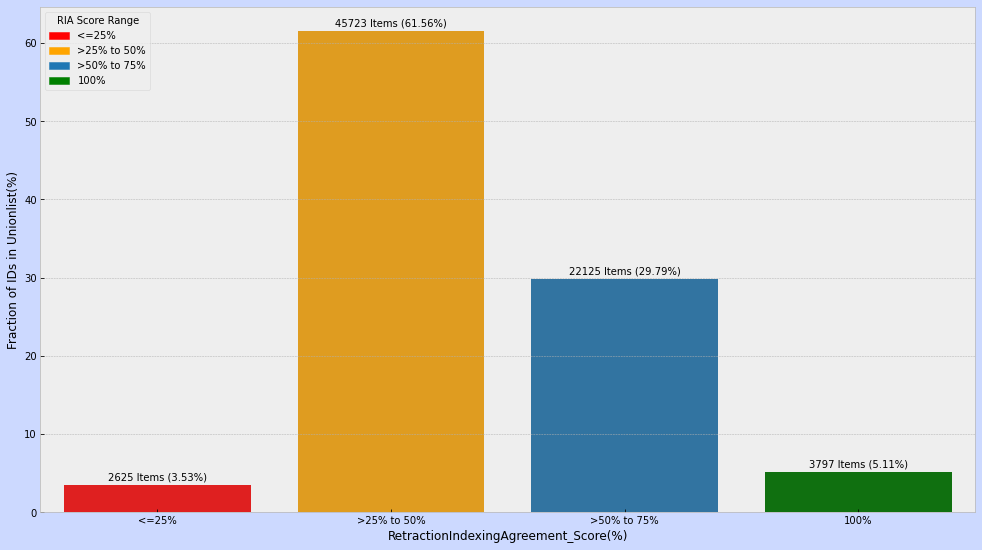

In [155]:
"""
Retraction Indexing Agreement by Items (in Group) for the Entire Unionlist_CRWS
"""

plt.style.use('bmh')
fig000, ax000 = plt.subplots(figsize=(14, 8))

mycolor_000 = dict(zip(table000['RIA_Score(%)'], table000['Color']))

# Create the bar plot
sns.barplot(y=table000['Fraction_in_Unionlist(%)'], x=table000['RIA_Score(%)'],
            ax=ax000, color="#1f77b4",palette=mycolor_000, ci=None)

#Add custom legend
legend_labels = {
    'red': '<=25%',
    'orange': '>25% to 50%',
    '#1f77b4': '>50% to 75%',
    'green': '100%',

}


legend_handles = [mpatches.Patch(color=color, label=label) for color, label in legend_labels.items()]

ax000.legend(handles=legend_handles, title="RIA Score Range", loc="upper left")


# Label bars with noDOIs values
for bar, noDOIs, frc in zip(ax000.patches, table000['noDOIs'],table000['Fraction_in_Unionlist(%)']):
    ax000.annotate(f"{noDOIs} Items ({frc}%)", #f"{noDOIs} / {len(unionlist3)}"
                      xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

# Set labels and title
ax000.set_xlabel("RetractionIndexingAgreement_Score(%)")
ax000.set_ylabel("Fraction of IDs in Unionlist(%)")
# ax3_01_1.set_title("Percentage of DOIs with their RIA_Score in Unionlist", size=13)

fig000.patch.set_facecolor('#ccd9ff') 
plt.tight_layout(pad=2.0)

In [166]:
"""
Distribution of RetractionIndexingAgreement of the newly Unionlist_CRW (exclusive source filtered)
"""
newly_added_crws_filtered = unionlist_crws_filtered[unionlist_crws_filtered['DOI'].isin(newly_added_crws['DOI'])]

table001= count_DOIs_for_RIA(newly_added_crws_filtered)
table001

,noDOIs,Fraction_in_Unionlist(%),RIA_Score(%),Color
0,2249,8.07,<=25%,red
1,20521,73.60,>25% to 50%,orange
2,4834,17.34,>50% to 75%,#1f77b4
3,278,1.00,100%,green


In [183]:
"""
Distribution of RetractionIndexingAgreement(RIA) of the STI2023 (exclusive source filtered)
- We obtain STI2023 (excluding exclusive indexed & coverd items) from Unionlist_CRWS -- using present RIA 
"""
sti2023_filtered = unionlist_crws_filtered[unionlist_crws_filtered['DOI'].isin(unionlist_sti['DOI'])]

table002= count_DOIs_for_RIA(sti2023_filtered)
table002

,noDOIs,Fraction_in_Unionlist(%),RIA_Score(%),Color
0,376,0.81,<=25%,red
1,25202,54.33,>25% to 50%,orange
2,17291,37.27,>50% to 75%,#1f77b4
3,3519,7.59,100%,green


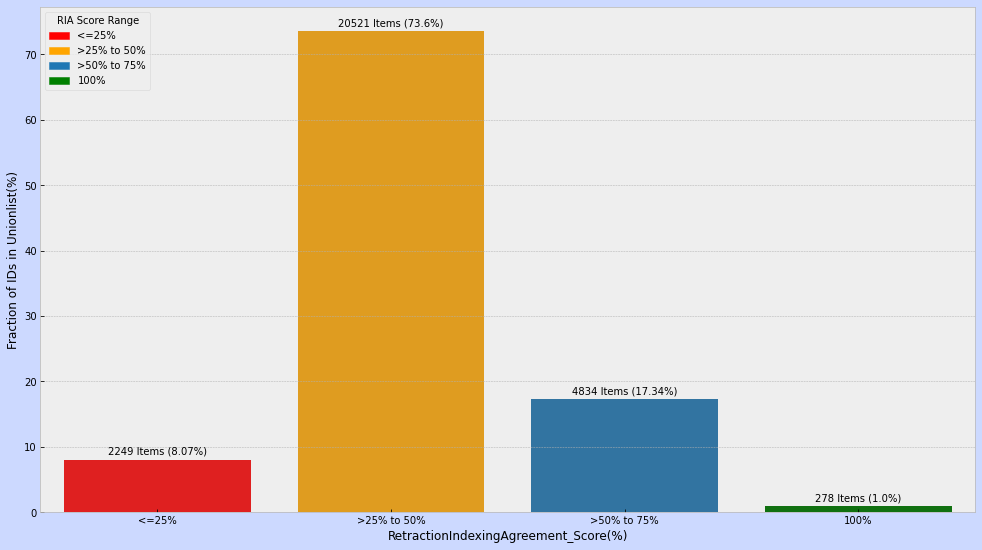

In [207]:
"""
Retraction Indexing Agreement by Items (in Group) for the newly added DOIs(from Unionlist_CRWS) 
to STI2023 unionlist
"""

plt.style.use('bmh')
fig001, ax001 = plt.subplots(figsize=(14, 8))

mycolor_001 = dict(zip(table001['RIA_Score(%)'], table001['Color']))

# Create the bar plot
sns.barplot(y=table001['Fraction_in_Unionlist(%)'], x=table001['RIA_Score(%)'],
            ax=ax001, color="#1f77b4",palette=mycolor_001, ci=None)

#Add custom legend
legend_labels = {
    'red': '<=25%',
    'orange': '>25% to 50%',
    '#1f77b4': '>50% to 75%',
    'green': '100%',

}



legend_handles = [mpatches.Patch(color=color, label=label) for color, label in legend_labels.items()]

ax001.legend(handles=legend_handles, title="RIA Score Range", loc="upper left")


# Label bars with noDOIs values
for bar, noDOIs, frc in zip(ax001.patches, table001['noDOIs'],table001['Fraction_in_Unionlist(%)']):
    ax001.annotate(f"{noDOIs} Items ({frc}%)", #f"{noDOIs} / {len(unionlist3)}"
                      xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

# Set labels and title
ax001.set_xlabel("RetractionIndexingAgreement_Score(%)")
ax001.set_ylabel("Fraction of IDs in Unionlist(%)")
# ax3_01_1.set_title("Percentage of DOIs with their RIA_Score in Unionlist", size=13)

fig001.patch.set_facecolor('#ccd9ff') 
plt.tight_layout(pad=2.0)

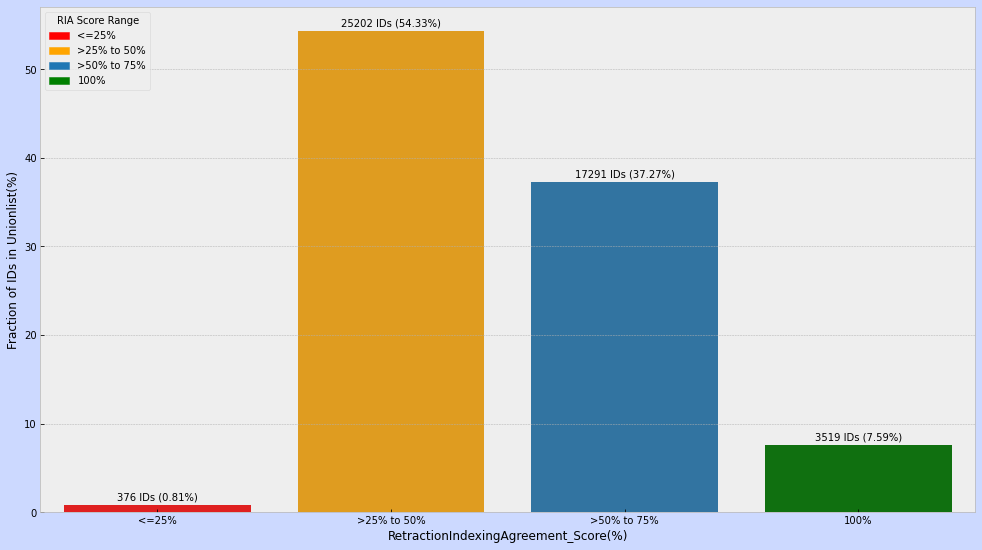

In [209]:
"""
Retraction Indexing Agreement by Items (in Group) for STI2023
"""

plt.style.use('bmh')
fig002, ax002 = plt.subplots(figsize=(14, 8))

mycolor_002 = dict(zip(table002['RIA_Score(%)'], table002['Color']))

# Create the bar plot
sns.barplot(y=table002['Fraction_in_Unionlist(%)'], x=table002['RIA_Score(%)'],
            ax=ax002, color="#1f77b4",palette=mycolor_002, ci=None)

#Add custom legend
#Add custom legend
legend_labels = {
    'red': '<=25%',
    'orange': '>25% to 50%',
    '#1f77b4': '>50% to 75%',
    'green': '100%',

}


legend_handles = [mpatches.Patch(color=color, label=label) for color, label in legend_labels.items()]

ax002.legend(handles=legend_handles, title="RIA Score Range", loc="upper left")


# Label bars with noDOIs values
for bar, noDOIs, frc in zip(ax002.patches, table002['noDOIs'],table002['Fraction_in_Unionlist(%)']):
    ax002.annotate(f"{noDOIs} IDs ({frc}%)", #f"{noDOIs} / {len(unionlist3)}"
                      xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      xytext=(0, 3), # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

# Set labels and title
ax002.set_xlabel("RetractionIndexingAgreement_Score(%)")
ax002.set_ylabel("Fraction of IDs in Unionlist(%)")
# ax3_01_1.set_title("Percentage of DOIs with their RIA_Score in Unionlist", size=13)

fig002.patch.set_facecolor('#ccd9ff') 
plt.tight_layout(pad=2.0)

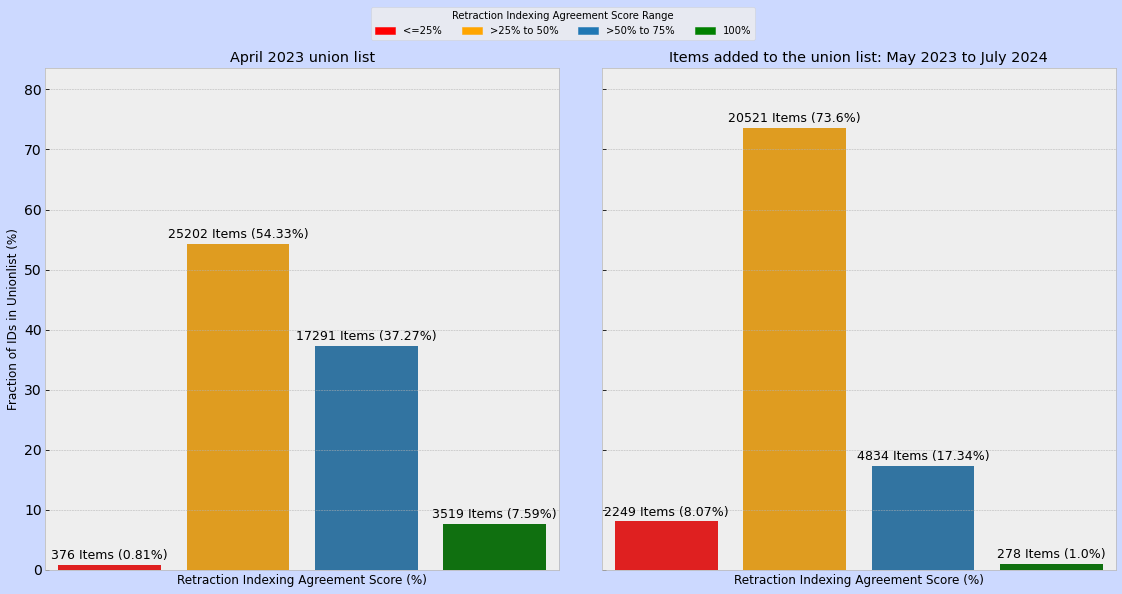

In [450]:
"""
Subplot for table000 & table0001
"""

plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plotting table002 -  STI2023
mycolor_002 = dict(zip(table000['RIA_Score(%)'], table000['Color']))
sns.barplot(y=table002['Fraction_in_Unionlist(%)'], x=table000['RIA_Score(%)'], 
            ax=ax1, palette=mycolor_000, ci=None)
ax1.set_title('April 2023 union list')
ax1.set_xlabel("Retraction Indexing Agreement Score (%)")
ax1.set_ylabel("Fraction of IDs in Unionlist (%)")
ax1.tick_params(axis='y', labelsize=14) 



# Plotting table001 - Newly added items to STI2023
mycolor_001 = dict(zip(table001['RIA_Score(%)'], table001['Color']))
sns.barplot(y=table001['Fraction_in_Unionlist(%)'], x=table001['RIA_Score(%)'], 
            ax=ax2, palette=mycolor_001, ci=None)
ax2.set_title('Items added to the union list: May 2023 to July 2024')
ax2.set_xlabel("Retraction Indexing Agreement Score (%)", fontsize=12)
ax2.set_ylabel("")
# ax2.yaxis.set_visible(True)
ax2.tick_params(axis='x', labelsize=14) 
ax2.set_xticks([])

# Remove y-axis labels and ticks from the second subplot
ax2.set_yticklabels([])
ax2.set_yticks([])

# Find the maximum y-value for setting the same y-axis scale
max_y = max(table000['Fraction_in_Unionlist(%)'].max(), table001['Fraction_in_Unionlist(%)'].max())

# Set the same y-axis limits and ticks for both subplots
for ax in [ax1, ax2]:
    ax.set_ylim(0, max_y + 10)  # Add some padding at the top
    ax.set_yticks(range(0, int(max_y) + 11, 10))
    ax.set_xticks([])



# Create a combined legend
legend_labels = {
    'red': '<=25%',
    'orange': '>25% to 50%',
    '#1f77b4': '>50% to 75%',
    'green': '100%'
}

legend_handles = [mpatches.Patch(color=color, label=label) for color, label in legend_labels.items()]

# Place the combined legend outside the top of the plot
fig.legend(handles=legend_handles, title="Retraction Indexing Agreement Score Range", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

# Label bars with noDOIs values for table000
for bar, noDOIs, frc in zip(ax1.patches, table002['noDOIs'], table002['Fraction_in_Unionlist(%)']):
    ax1.annotate(f"{noDOIs} Items ({frc}%)",
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  xytext=(0, 3),
                  textcoords="offset points",fontsize=12.5, 
                  ha='center', va='bottom')

# Label bars with noDOIs values for table001
for bar, noDOIs, frc in zip(ax2.patches, table001['noDOIs'], table001['Fraction_in_Unionlist(%)']):
    ax2.annotate(f"{noDOIs} Items ({frc}%)",
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  xytext=(0, 3),
                  textcoords="offset points",fontsize=12.5, 
                  ha='center', va='bottom')

# Customize figure appearance
fig.patch.set_facecolor('#ccd9ff')
plt.tight_layout(pad=2.0, rect=[0, 0, 1, 1])  # Adjust layout to make room for legend

plt.savefig(result_dir+'unionlist_ria_proportion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



### Investigating Missing DOIs

In [221]:
print(f'The Actual # DOIs in STI2023 found in unionlist_crws 2024 is {len(common_df)}')

missing_sti_dois= set(unionlist_sti['DOI']) - set(common_df['DOI'])
print(f'The # missing DOIs of STI2023 not found in unionlist_crws 2024 is {len(missing_sti_dois)}')

The Actual # DOIs in STI2023 found in unionlist_crws 2024 is 49497
The # missing DOIs of STI2023 not found in unionlist_crws 2024 is 427


In [222]:
"""
Data Quality Check:
Missing records in STI2023 when cross-matched with unionlist_crws 2024
"""

missing_df= unionlist_sti[unionlist_sti['DOI'].isin(missing_sti_dois)]
# missing_df.to_csv(result_dir+'missing_doi_insti2023.csv',index=False)
missing_df

,DOI,Author,Title,Year,Journal,source,PubMedID,JournalandConferenceProceedings_lowercase,MainCategory
72,10.1002/(sici)1098-2396(199905)32:2<141::aid-s...,"Rothman, RB",Is phentermine an inhibitor of monoamine oxida...,1999,SYNAPSE,Web of Science,10231134,synapse,Life Sciences
2037,10.1002/2211-5463.13229,NaN,"Retraction: Ma, X., Zou, L., Chen, Z., Li, X.,...",2021,FEBS Open Bio,Crossref,0,febs open bio,Life Sciences
2077,10.1002/adhm.202002223,"Dahmani, Fatima Zohra; Xiao, Yan; Zhang, Juan;...",RETRACTED: Multifunctional Polymeric Nanosyste...,2021,Advanced healthcare materials,Web of Science,33470552,advanced healthcare materials,"Life Sciences,Physical Sciences"
2141,10.1002/anie.202006167,"Hudlicky, T",RETRACTION: RETRACTED: Withdrawal: 'Organic sy...,2020,Angewandte Chemie (International ed. in English),Web of Science,32598092,angewandte chemie (international ed. in english),"Life Sciences, Health Sciences, Physical Scien..."
2381,10.1002/cpt.1708,NaN,Withdrawal: “A novel AKR1C3 specific prodrug T...,2019,Clinical Pharmacology &amp; Therapeutics,Crossref,0,clinical pharmacology &amp; therapeutics,"Life Sciences, Physical Sciences"
...,...,...,...,...,...,...,...,...,...
49652,10.5812/jjcdc.122443,"[{'given': 'Akram', 'family': 'Mohammadi Pelar...",Retraction Note: The Effects of Family-Centere...,2022,Jundishapur Journal of Chronic Disease Care,Crossref,0,jundishapur journal of chronic disease care,"Life Sciences, Health Sciences, Physical Scien..."
49708,10.6026/97320630011516,[Anonymous],RETRACTION: RETRACTED: Retraction for Singh et...,2015,Bioinformation,Web of Science,26912955,bioinformation,Physical Sciences
49733,10.7202/1058611ar,"Beaudoin, Melissa; Potvin, Stephane; Dellazizz...",RETRACTED: Characterization of First Episodes ...,2018,SANTE MENTALE AU QUEBEC,Web of Science,32338687,sante mentale au quebec,"Social Sciences,Health Sciences"
49769,10.7326/l18-0673,[Anonymous],RETRACTION: RETRACTED: Meal Size Explains Erro...,2019,ANNALS OF INTERNAL MEDICINE,Web of Science,30508431,annals of internal medicine,Health Sciences


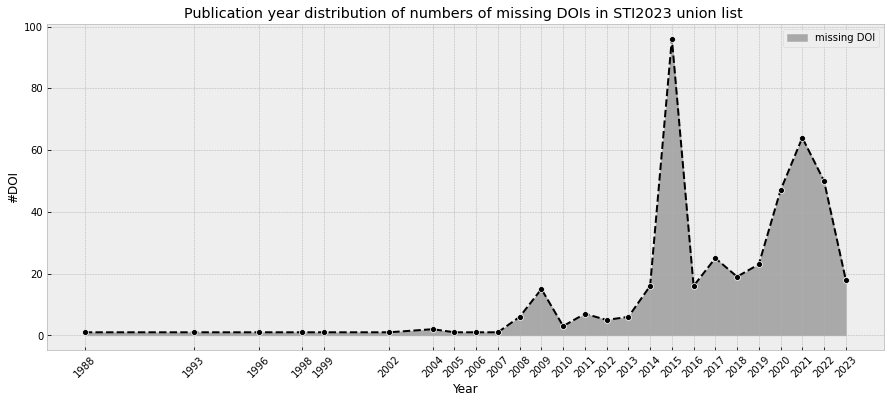

In [223]:
fig00, ax00 = plt.subplots(figsize=(15, 6))

# Group and count DOIs by year
missing_t = missing_df.groupby('Year')['DOI'].count().reset_index()

# Plot the lineplot
sns.lineplot(data=missing_t, x='Year', y='DOI', marker='o', ax=ax00, color='black', linestyle='--')

# Shade the area under the line plot
ax00.fill_between(missing_t['Year'], missing_t['DOI'], color='darkgray', alpha=1, label = 'missing DOI')

# Set the x-axis ticks to show every year
ax00.set_xticks(missing_t['Year'])
ax00.set_xticklabels(missing_t['Year'], rotation=45)

# Add titles and labels
ax00.set_title('Publication year distribution of numbers of missing DOIs in STI2023 union list ')
ax00.set_xlabel('Year')
ax00.set_ylabel('#DOI')
ax00.legend()

plt.show()

In [228]:

# Group by year and count DOIs
sti_year_t = unionlist_sti.groupby('Year')['DOI'].count().reset_index()
ul_year_t = common_df.groupby('Year')['DOI'].count().reset_index()

ul_year_t= ul_year_t.iloc[:-1,:].copy() # Remove 2024 year because of plotting

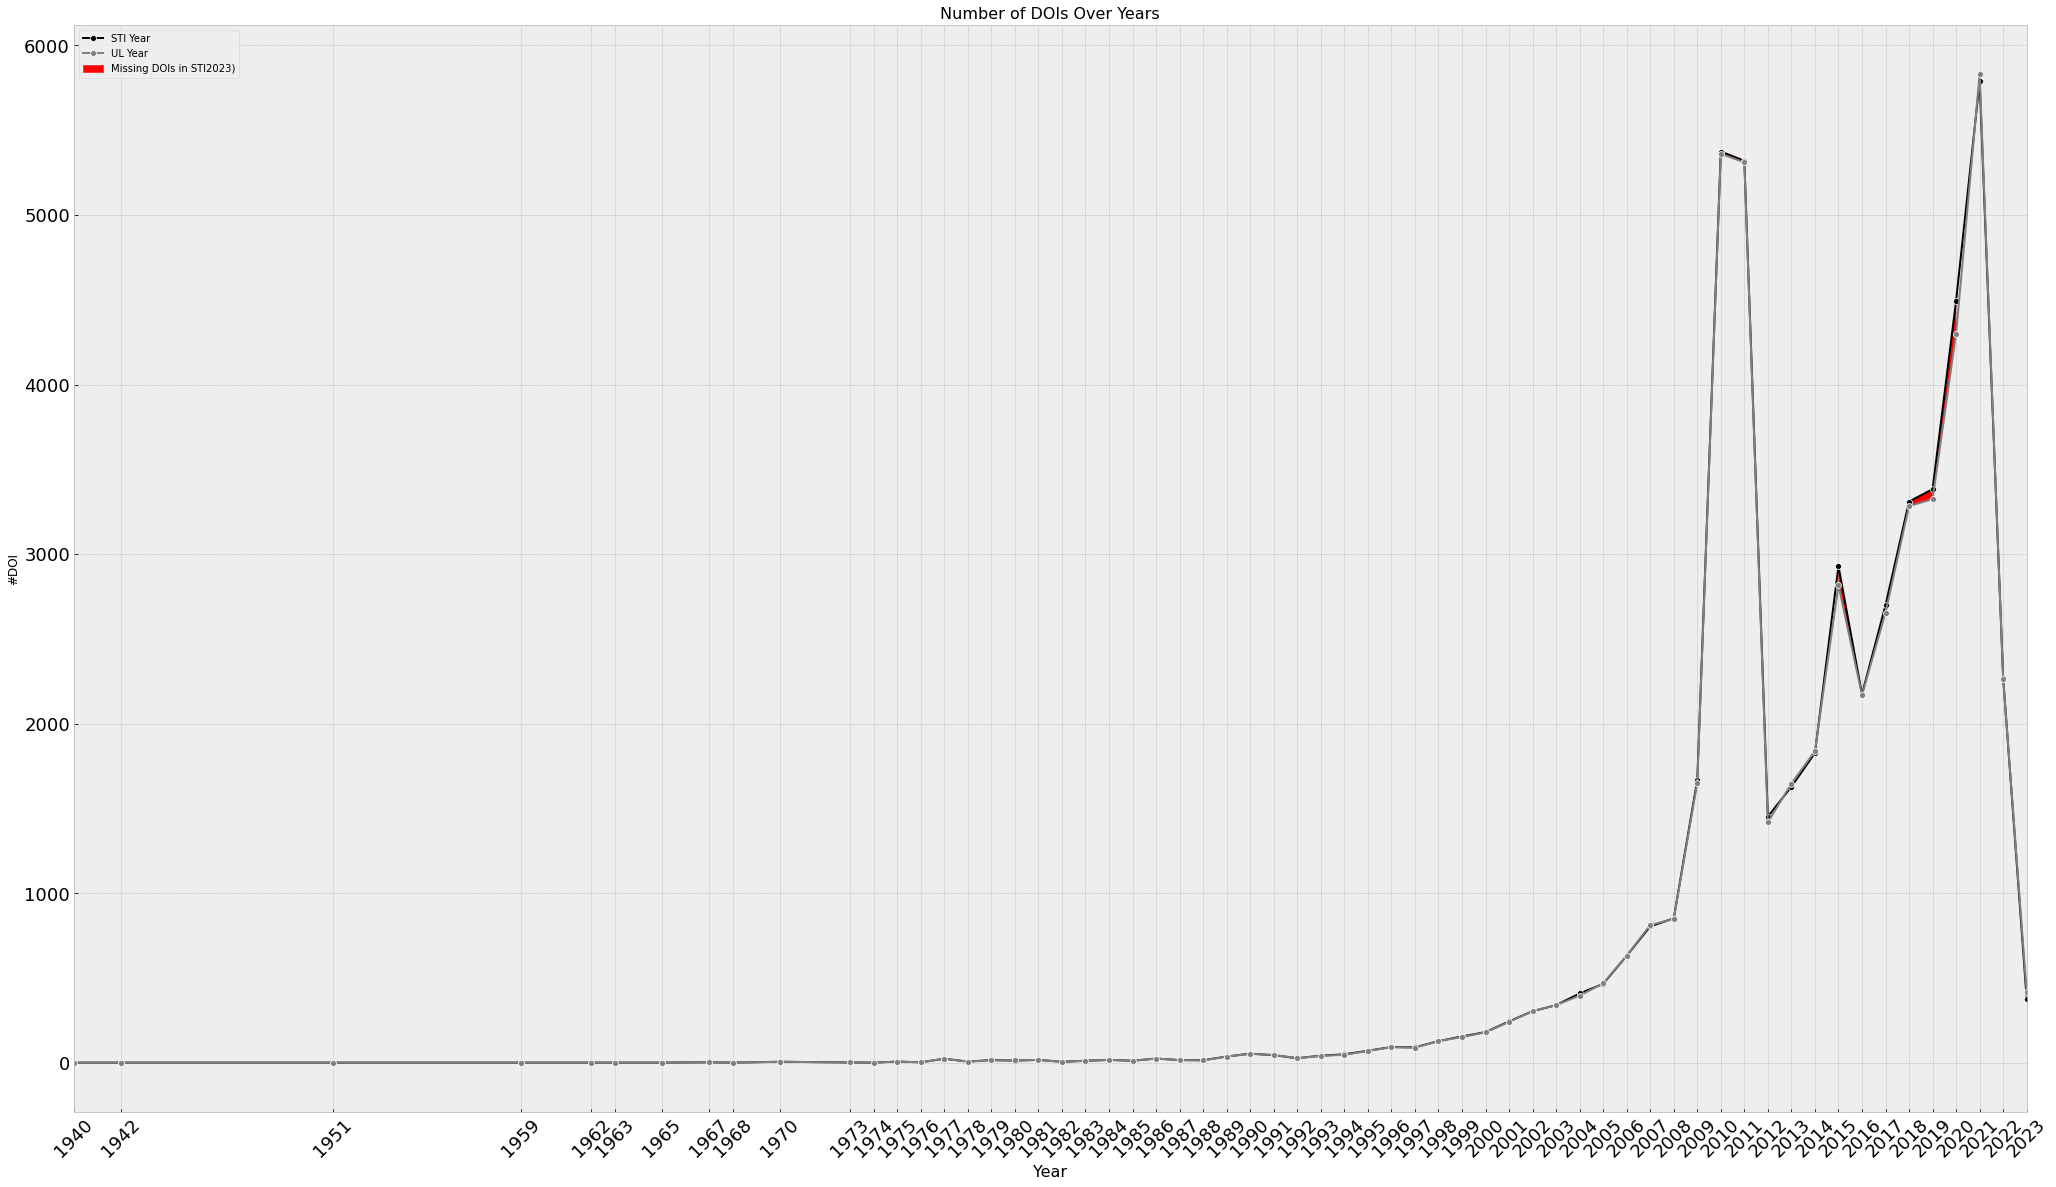

In [230]:
"""
Plotting trends of retracted publications in STI2023 indicating missing DOIs - 1
"""

fig01, ax01 = plt.subplots(figsize=(35, 20))

# Plot the line plots
sns.lineplot(data=sti_year_t, x='Year', y='DOI', marker='o', ax=ax01, color='black', label='STI Year')
sns.lineplot(data=ul_year_t, x='Year', y='DOI', marker='o', ax=ax01, color='grey', label='UL Year')

# Ensure x-axis is the same for both plots
ax01.set_xlim(min(sti_year_t['Year'].min(), ul_year_t['Year'].min()), max(sti_year_t['Year'].max(), ul_year_t['Year'].max()))

# Fill the area between the lines
# Ensure both DataFrames cover the same years
combined_years = sorted(set(sti_year_t['Year']).union(ul_year_t['Year']))
sti_year_t = sti_year_t.set_index('Year').reindex(combined_years, fill_value=0).reset_index()
ul_year_t = ul_year_t.set_index('Year').reindex(combined_years, fill_value=0).reset_index()

plt.fill_between(sti_year_t['Year'], sti_year_t['DOI'], ul_year_t['DOI'], where=(sti_year_t['DOI'] > ul_year_t['DOI']),
                 color='red', alpha=1, label='Missing DOIs in STI2023)')

# Set the x-axis ticks to show every year
ax01.set_xticks(combined_years)
ax01.set_xticklabels(combined_years, rotation=45)

# Increase font size of tick labels
ax01.tick_params(axis='both', which='major', labelsize=18)

# Add titles and labels
ax01.set_title('Number of DOIs Over Years',fontsize=16)
ax01.set_xlabel('Year',  fontsize=16)
ax01.set_ylabel('#DOI')
ax01.legend()

# Display the plot
plt.show()


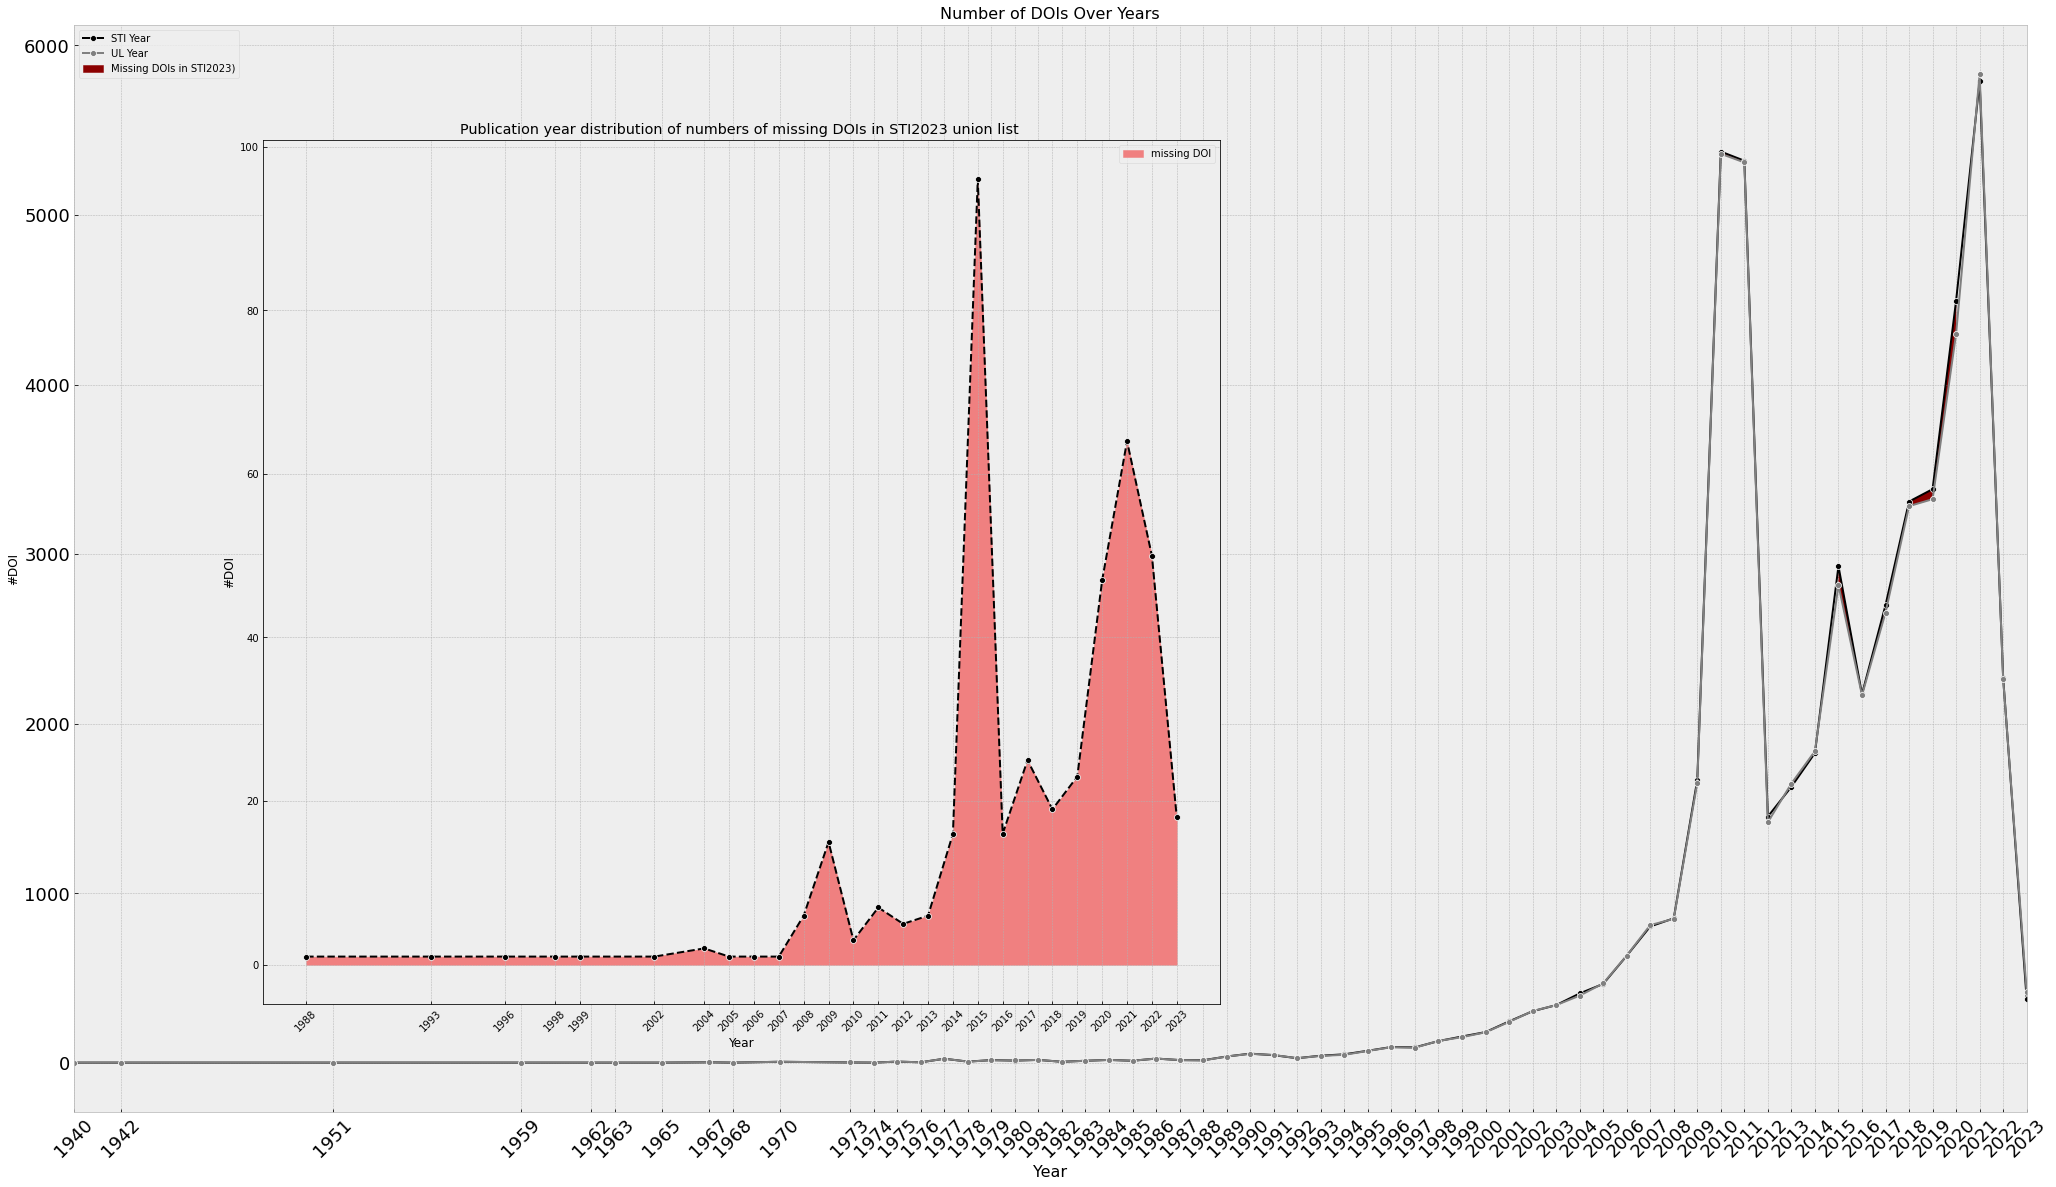

In [231]:
"""
Plotting trends of retracted publications in STI2023 indicating missing DOIs - 2
"""

fig01, ax01 = plt.subplots(figsize=(35, 20))
# Plot the line plots
sns.lineplot(data=sti_year_t, x='Year', y='DOI', marker='o', ax=ax01, color='black', label='STI Year')
sns.lineplot(data=ul_year_t, x='Year', y='DOI', marker='o', ax=ax01, color='grey', label='UL Year')

# Ensure x-axis is the same for both plots
ax01.set_xlim(min(sti_year_t['Year'].min(), ul_year_t['Year'].min()), max(sti_year_t['Year'].max(), ul_year_t['Year'].max()))

# Fill the area between the lines
# Ensure both DataFrames cover the same years
combined_years = sorted(set(sti_year_t['Year']).union(ul_year_t['Year']))
sti_year_t = sti_year_t.set_index('Year').reindex(combined_years, fill_value=0).reset_index()
ul_year_t = ul_year_t.set_index('Year').reindex(combined_years, fill_value=0).reset_index()

plt.fill_between(sti_year_t['Year'], sti_year_t['DOI'], ul_year_t['DOI'], where=(sti_year_t['DOI'] > ul_year_t['DOI']),
                 color='darkred', alpha=1, label='Missing DOIs in STI2023)')

plt.fill_between(sti_year_t['Year'], sti_year_t['DOI'], ul_year_t['DOI'], where=(sti_year_t['DOI'] < ul_year_t['DOI']),
                 color='darkred', alpha=1, )
# Set the x-axis ticks to show every year
ax01.set_xticks(combined_years)
ax01.set_xticklabels(combined_years, rotation=45)

# Increase font size of tick labels
ax01.tick_params(axis='both', which='major', labelsize=18)

# Add titles and labels
ax01.set_title('Number of DOIs Over Years',fontsize=16)
ax01.set_xlabel('Year',  fontsize=16)
ax01.set_ylabel('#DOI')
ax01.legend()


###
fig00, ax00 
ax00= fig01.add_axes([0.2, 0.2, 0.38, 0.6],  frameon=True,)  #[0.18, 0.5, 0.55, 0.35] [left, bottom, width, height]
for spine in ax00.spines.values():
    spine.set_edgecolor('black')
    
# Plot the lineplot
sns.lineplot(data=missing_t, x='Year', y='DOI', marker='o', ax=ax00, color='black', linestyle='--')

# Shade the area under the line plot
ax00.fill_between(missing_t['Year'], missing_t['DOI'], color='lightcoral', alpha=1, label = 'missing DOI')

# color='lightcoral' - light red
# Set the x-axis ticks to show every year
ax00.set_xticks(missing_t['Year'])
ax00.set_xticklabels(missing_t['Year'], rotation=45)

# Add titles and labels
ax00.set_title('Publication year distribution of numbers of missing DOIs in STI2023 union list ')
ax00.set_xlabel('Year')
ax00.set_ylabel('#DOI')
ax00.legend()

# Display the plot
plt.show()


In [243]:
"""
Examining changes between STI2023 and the unionlist_CRWS2024 unionlists
"""

combined_df= pd.merge(sti_year_t,ul_year_t, how='inner',on='Year')

combined_df.rename(columns={'DOI_x': 'DOI_STI', 'DOI_y':'DOI_Present'}, inplace=True)
combined_df



,Year,DOI_STI,DOI_Present
0,1940,1,1
1,1942,1,1
2,1951,1,1
3,1959,1,1
4,1962,1,1
...,...,...,...
56,2019,3383,3324
57,2020,4495,4300
58,2021,5788,5830
59,2022,2269,2262


In [244]:
"""
Calculating the breakdown of missing DOIs in STI2023 union list

Extract missing DOIs for each sources
"""

# missing_df[missing_df['source_old'].apply(lambda col: col if 'WoS_Core' in col)]
msDOI_wos= missing_df[missing_df['source'].str.contains('Web of Science')]['DOI'].tolist()
msDOI_crossref= missing_df[missing_df['source'].str.contains('Crossref')]['DOI'].tolist()
msDOI_scopus= missing_df[missing_df['source'].str.contains('Scopus')]['DOI'].tolist()
msDOI_rw= missing_df[missing_df['source'].str.contains('Retraction Watch')]['DOI'].tolist()

print(f'# total missing DOIs in STI2023 is {len(missing_df)} DOIs')
print(f'# total missing DOIs in Crossref is {len(msDOI_crossref)} DOIs')
print(f'# total missing DOIs in Retraction Watch is {len(msDOI_rw)} DOIs')
print(f'# total missing DOIs in Scopus is {len(msDOI_scopus)} DOIs')
print(f'# total missing DOIs in Web of Science is {len(msDOI_wos)} DOIs')

# total missing DOIs in STI2023 is 427 DOIs
# total missing DOIs in Crossref is 208 DOIs
# total missing DOIs in Retraction Watch is 45 DOIs
# total missing DOIs in Scopus is 72 DOIs
# total missing DOIs in Web of Science is 105 DOIs


In [245]:
msDOI_wos

['10.1002/(sici)1098-2396(199905)32:2<141::aid-syn8>3.3.co;2-i',
 '10.1002/adhm.202002223',
 '10.1002/anie.202006167',
 '10.1002/ejhf.2_536',
 '10.1002/jcp.28675',
 '10.1007/s00125-015-3687-4',
 '10.1007/s00395-018-0676-z',
 '10.1007/s10067-009-1193-0',
 '10.1007/s11010-022-04355-x',
 '10.1007/s11010-022-04373-9',
 '10.1007/s12029-017-0028-5',
 '10.1007/s13277-013-1573-6',
 '10.1016/52213-8587(17)30366-2',
 '10.1016/s0140-6736(20)31324-6',
 '10.1016/j.ajog.2014.01.018',
 '10.1016/j.apjtm.2017.06.014',
 '10.1016/j.apjtm.2017.06.015',
 '10.1016/j.ecoenv.2018.02.019',
 '10.1016/j.ejpb.2019.07.022',
 '10.1016/j.intimp.2017.08.024',
 '10.1016/j.jaci.2008.11.012',
 '10.1016/j.jcin.2017.06.054',
 '10.1016/j.pathol.2020.04.001',
 '10.1016/j.talanta.2018.04.037',
 '10.1021/jf9002895',
 '10.1038/cddis.2017.358',
 '10.1038/s41467-019-08320-z',
 '10.1046/j.1365-2346.1998.00267.x',
 '10.1080/10464883.2021.1956826',
 '10.1089/aid.2020.0307.retract',
 '10.1089/dna.2017.3798.retract',
 '10.1093/annonc

In [247]:
"""
Write missing DOIs in STI2023 in files 
"""
# Write the set to the file



# Missing DOIs in Crossref
with open(result_dir+"sti_missingdoi_incrossref.txt", "w") as file:
    for item in msDOI_crossref:
        file.write(item + "\n")

# Missing DOIs in Retraction Watch
with open(result_dir+"sti_missingdoi_inretractionwatch.txt", "w") as file:
    for item in msDOI_rw:
        file.write(item + "\n")
        
# Missing DOIs in Scopus
with open(result_dir+"sti_missingdoi_inscopus.txt", "w") as file:
    for item in msDOI_scopus:
        file.write(item + "\n")
        
# Missing DOIs in Web of Science
with open(result_dir+"sti_missingdoi_inwos.txt", "w") as file:
    for item in msDOI_wos:
        file.write(item + "\n")

In [248]:
def batch_items(pmids:list, cut:int)-> list[list]:
    """
    It divides the list of items into batches for processing. 
    :param pmids: list of items 
    :param cut: maximum number of records to assign to a batch
    
    :return: list of list of batches of pmids
    """
    pmids_batches=[]
    
    while len(pmids) >= cut:
        selected_pmids= pmids[:cut]
        pmids_batches.append(selected_pmids)
#         print(selected_pmids)    
        pmids = pmids[cut:]

    if pmids:
        pmids_batches.append(pmids)
#         print(pmids)

    return pmids_batches



#### Checking missing DOIs coverage in Crossref


In [253]:
from crossref.restful import Works, Etiquette
my_etiquette = Etiquette('Retraction Indexing Assessment', 'version2', 'no url', my_email)
#my_etiquette = Etiquette('My Project Name', 'My Project version', 'My Project URL', 'My contact email')
works = Works(etiquette=my_etiquette)


In [254]:
cut= 50
check_doi_in_crossref= msDOI_crossref # change scopus to notindexedasretracted_source

check_doi_in_crossref_batches = batch_items(check_doi_in_crossref, cut) #check_doi_in_scopus


print(f'The total items to search in Crossref is {len(check_doi_in_crossref)}, which are divided into {len(check_doi_in_crossref_batches)} batches')

The total items to search in Crossref is 208, which are divided into 5 batches


In [256]:
"""
Check DOI Coverage in Crossref
"""



new = Works()
start = time.time()

crossref_covered_doi=[]


for i in tqdm(check_doi_in_crossref):
    try:
        for j in new.filter(doi = i).select('DOI'):
            find = j['DOI']
            if i == find:
                crossref_covered_doi.append(i)

    except Exception:
            pass
    time.sleep(0.10)
        #print(i)


100%|█████████████████████████████████████████| 208/208 [02:25<00:00,  1.43it/s]


In [259]:
print(f'The total # missing DOIs found in Crossref is {len(crossref_covered_doi)}')
print (f'The missing DOIs now not covered in Crossref is {len(set(msDOI_crossref) - set(crossref_covered_doi))} DOI')
set(msDOI_crossref) - set(crossref_covered_doi)

The total # missing DOIs found in Crossref is 208
The missing DOIs now not covered in Crossref is 0 DOI


set()

In [ ]:
"""
All the missing DOIs in Crossef were found - # already written to file -> sti_missingdoi_incrossref
"""


In [ ]:
"""
Investigate found missing DOIs in Crossref
"""

crossref_covered_doi

In [73]:
crossref_covered_doi

['10.1002/2211-5463.13229',
 '10.1002/cpt.1708',
 '10.1002/jcb.29943',
 '10.1007/s10854-020-02970-2',
 '10.1007/s11192-022-04353-2',
 '10.1007/s12031-019-01407-8',
 '10.1007/s12197-015-9335-5',
 '10.1007/s41127-018-0022-0',
 '10.1016/j.acra.2022.12.029',
 '10.1016/j.ajog.2022.08.019',
 '10.1016/j.comnet.2023.109702',
 '10.1016/j.gete.2023.100440',
 '10.1016/j.gim.2022.09.015',
 '10.1016/j.ica.2022.121127',
 '10.1016/j.ijdevneu.2015.04.012',
 '10.1016/j.ijdevneu.2015.04.013',
 '10.1016/j.ijdevneu.2015.04.014',
 '10.1016/j.ijdevneu.2015.04.015',
 '10.1016/j.ijdevneu.2015.04.016',
 '10.1016/j.ijdevneu.2015.04.018',
 '10.1016/j.ijdevneu.2015.04.019',
 '10.1016/j.ijdevneu.2015.04.020',
 '10.1016/j.ijdevneu.2015.04.022',
 '10.1016/j.ijdevneu.2015.04.023',
 '10.1016/j.ijdevneu.2015.04.024',
 '10.1016/j.ijdevneu.2015.04.025',
 '10.1016/j.ijdevneu.2015.04.026',
 '10.1016/j.ijdevneu.2015.04.029',
 '10.1016/j.ijdevneu.2015.04.031',
 '10.1016/j.ijdevneu.2015.04.033',
 '10.1016/j.ijdevneu.2015.04.0

In [260]:
# DOIs that starts with '10.1016/j.ijdevneu.2015.' ... '10.1016/j.ijdevneu.2015.04.317'
c = 0
for doi in crossref_covered_doi:
    if doi.startswith('10.1016/j.ijdevneu.2015.'):
        c+=1 
print(f"The total # DOI that starts with '10.1016/j.ijdevneu.2015.04....': {(c)}")

The total # DOI that starts with '10.1016/j.ijdevneu.2015.04....': 84


In [ ]:
"""
Investigated a Few missing DOIs (others are in the spreadsheet -> STI2023_missingDOI_analysis)

- '10.1016/j.ijdevneu.2015.04.012' ...'10.1016/j.ijdevneu.2015.04.317' (84): removed due "Due to an administrative error, 
    abstracts that were not presented at the ISDN 2014 meeting were inadvertently published in the meeting's abstract supplement."
- '10.1002/2211-5463.13229' :retraction notice
- '10.1002/cpt.1708' : withdrawal notice
- '10.1007/s10854-020-02970-2': correction a paper (now retracted)
- '10.1007/s11192-022-04353-2' : False positive - bcos its title Citing documents of Wakefield’s retracted article: the domino effect of authors and journals
- ''
"""


In [261]:
unionlist_sti[unionlist_sti['DOI']=='10.1002/cpt.1708']

,DOI,Author,Title,Year,Journal,source,PubMedID,JournalandConferenceProceedings_lowercase,MainCategory
2381,10.1002/cpt.1708,NaN,Withdrawal: “A novel AKR1C3 specific prodrug T...,2019,Clinical Pharmacology &amp; Therapeutics,Crossref,0,clinical pharmacology &amp; therapeutics,"Life Sciences, Physical Sciences"


#### Checking missing DOIs coverage in Scopus

In [262]:
"""
Break the list of DOIs to search into batches of a maximum of 25 items in each batch. 
The limit per page for Scopus is 25 items at a time.

Input:
    cut: maximum number items in a batch
"""
scopus_cut= 25
check_doi_in_scopus= msDOI_scopus 

check_doi_in_scopus_batches = batch_items(check_doi_in_scopus, scopus_cut) #check_doi_in_scopus


print(f'The total items to search in Scopus is {len(check_doi_in_scopus)}, which are divided into {len(check_doi_in_scopus_batches)} batches')
print(f'The items list is divided into lists in which each list contains {scopus_cut} records maximum')

The total items to search in Scopus is 72, which are divided into 3 batches
The items list is divided into lists in which each list contains 25 records maximum


In [263]:
"""
Checking DOIs coverage in Scopus
"""

scopus_covered_doi = []
scopus_unresolved_doi = []

# Set your API key
api_key = elsevier_api_key
elsevier_insttoken = elsevier_insttoken

url_base = "https://api.elsevier.com/content/search/scopus" 
headers = {
        'X-ELS-APIKey': api_key,
        'Accept': 'application/json',
        'X-ELS-Insttoken':elsevier_insttoken}


for batch in tqdm(check_doi_in_scopus_batches[:]):
    
    # Putting search format 'DOI(10.1038/s41598-023-31439-5) OR DOI(...)'
    check_now = ' OR '.join(f'DOI({doi})' for doi in batch) 
    params= {"query": check_now}
        
    response = requests.get(url_base,
                        headers= headers,
                    params = params)
    
    if response.status_code == 200:
        results = response.json()

        store=[]
            
        totalresult= int(results['search-results'].get('opensearch:totalResults',0))
    
        if totalresult > 0:
        
            try:
                for result in results['search-results']['entry']:
                    try:
                        store.append(result['prism:doi'])
                    except KeyError:
                        pass
                        scopus_unresolved_doi.extend(batch)
            except KeyError:
                pass
    else:
        scopus_unresolved_doi.extend(batch)

    scopus_covered_doi.extend(store)
    
    time.sleep(0.15)


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


In [264]:

print(f'The total # missing DOIs covered in Scopus is {len(scopus_covered_doi)}')
print (f'The missing DOIs now not covered in Scopus is {len(set(msDOI_scopus) - set(scopus_covered_doi))} DOI')
set(msDOI_scopus) - set(scopus_covered_doi)
# scopus_unresolved_doi

The total # missing DOIs covered in Scopus is 71
The missing DOIs now not covered in Scopus is 1 DOI


{'10.1063/1.5032937'}

In [215]:
"""
All the missing DOIs in Crossef were found - # already written to file -> sti_missingdoi_inscopus
except {'10.1063/1.5032937'}
"""
scopus_covered_doi

['10.1016/j.conbuildmat.2022.127319',
 '10.1016/j.bbrc.2021.12.021',
 '10.1016/j.bspc.2021.103476',
 '10.1016/j.dib.2021.107782',
 '10.1016/j.ecolind.2021.108521',
 '10.1016/j.arth.2021.10.017',
 '10.1016/j.arth.2021.10.019',
 '10.1016/j.autneu.2021.102897',
 '10.1016/j.actaastro.2021.09.009',
 '10.1016/j.ensm.2021.08.029',
 '10.1016/j.ejca.2021.08.018',
 '10.1016/j.ecolind.2021.108211',
 '10.1016/j.earscirev.2021.103744',
 '10.1016/j.ekir.2021.06.013',
 '10.1016/j.arth.2021.05.001',
 '10.1016/j.colsurfa.2021.126674',
 '10.1016/j.buildenv.2021.107876',
 '10.1016/j.actbio.2021.03.064',
 '10.1016/j.apmt.2021.101000',
 '10.1016/j.eng.2021.02.007',
 '10.1016/j.actaastro.2021.01.032',
 '10.1016/j.arabjc.2020.09.039',
 '10.1016/j.biortech.2020.123263',
 '10.1016/j.apsusc.2019.144593',
 '10.1016/j.compedu.2019.103700',
 '10.1016/j.jclepro.2022.132425',
 '10.1016/j.jallcom.2022.164669',
 '10.1016/j.jhazmat.2021.128144',
 '10.1016/j.jallcom.2021.162839',
 '10.1016/j.jcis.2021.11.013',
 '10.1016

In [ ]:
"""
Investigated a Few missing DOIs (others are in the spreadsheet -> STI2023_missingDOI_analysis)

- 10.1016/j.scitotenv.2022.154307  # response to a letter / related to retraction
- 10.1016/j.bspc.2021.103476       # Corrigendum / Notrelated to retraction
- 10.1016/j.dib.2021.107782       # Corrigendum / Notrelated to retraction
- 10.1063/1.5032937 : No more available in the bibliograhic databases

"""

#### Checking missing DOIs coverage in Web of Science

In [265]:
def wos_check_DOI(DOIs_lists: list, database:str):
    c=0
    """
    It checks the coverage of DOI in the Web of Science
    
    :param DOIs_lists: list of list of DOIs preformatted to query form for Web of Science use
    :param database: specific the database to search
    
    :return: list of list [available DOIs, DOIs that ran into error]
    
    """
    c=0
    wos_covered_doi = []
    wos_unresolved_doi = []

    # Define your API key
    WoS_api_key = wos_api_key


    # Set the headers with the API key
    headers = {
            'X-ApiKey': WoS_api_key,
            'charset': 'UTF-8',
            'Encoding': 'UTF-8',
            'content-type':'text/xml'
            }
#     base_url = 'https://api.clarivate.com/apis/wos-starter/v1/documents' 
    url = 'https://api.clarivate.com/apis/wos-starter/v1/documents'

    for batch in tqdm(DOIs_lists):
        check_now = ' OR '.join(f'DO=({doi})' for doi in batch) 
#         print(check_now)

        params = {
            'db': database, #'WOK',#'WOS',
            'q': check_now,
            'limit': 50
        }



        # Make the API request
        response = requests.get(url, params=params, headers=headers)

        # Check if the request was successful (200 status code)
        if response.status_code == 200:
#             print('success')
            # Extract the response content as JSON
            data = response.json()
            # Print the DOI details
            try:
                dois_result = data['hits']
                for doi in dois_result:
                    try:
                        if doi.get('identifiers'):
                            identifiers = doi.get('identifiers','')
                            DOI= identifiers.get('doi','')
                            wos_covered_doi.append(DOI)
                    except Exception:
                        pass
            except Exception:
                pass
                wos_unresolved_doi.append(check_now)

        else:
            # If the request was not successful, print the error message
            print(f"Request failed with status code: {response.status_code} in batch: {c}")
            #print(response.text)

        time.sleep(0.15)
        #print('batch: ',c)
        c+=1 
        
    return [wos_covered_doi,wos_unresolved_doi]


In [266]:
"""
Break the list of DOIs to search into batches of a maximum of 50 items in each batch. 
The limit per page for Web of Science is 50 items at a time.

Input:
    cut: maximum number items in a batch
"""
wos_cut= 50
check_doi_in_woscore= msDOI_wos #woscoreDOI_notindexed['DOI'].tolist()# change doilist_wos to notindexedasretracted_source

check_doi_in_woscore_batches = batch_items(check_doi_in_woscore, wos_cut)

print(f'The total items to search in Web of Science Core is {len(check_doi_in_woscore)}, which are divided into {len(check_doi_in_woscore_batches)} batches')
print(f'The items list is divided into lists in which each list contains {wos_cut} records maximum')

The total items to search in Web of Science Core is 105, which are divided into 3 batches
The items list is divided into lists in which each list contains 50 records maximum


In [267]:
"""
Check DOIs Coverage in Web of Science Core
"""
start = time.time()

woscore_results= wos_check_DOI(check_doi_in_woscore_batches, 'WOS')

end = time.time()
end - start

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


2.210314989089966

In [273]:
unionlist_crws3[unionlist_crws3['DOI'].str.contains('10.1371/journal.pbio.3000825')]

,DOI,Author,Title,Year,Journal,PubMedID,source_new,source_old,RetractionIndexingAgreement_ITEM(%)
73983,10.1371/journal.pbio.3000825,"['Qi Y.J.,Jiao Y.L.,Chen P.,Kong J.Y.,Gu B.L.,...",Porphyromonas gingivalis promotes progression ...,2020,PLoS Biology,32886690,"[Crossref, Retraction Watch, Scopus, WoS_Core]","[Retraction Watch, Scopus, WoS_Core]",75


In [304]:

# Extracting DOIs that are still missing
notfound_doi_wos= list(set(msDOI_wos) - set(woscore_results[0]))

print(f'The total # missing DOIs found in Web of Science is {len(woscore_results[0])}')
print (f'The missing DOIs now not covered in Web of Science is {len(notfound_doi_wos)} DOI')
notfound_doi_wos[:15]

The total # missing DOIs found in Web of Science is 49
The missing DOIs now not covered in Web of Science is 67 DOI


['10.3760/cma.j.issn.0253-2727.2013.11.009',
 '10.4103/0970-0218.55288',
 '10.1210/jc.2018-01651',
 '10.2147/opth.s74959',
 '10.1021/jf9002895',
 '10.1556/oh.2011.29024',
 '10.1097/aog.0b013e3181ac06b6',
 '10.1016/s0140-6736(20)31324-6',
 '10.4103/1477-3163.75458',
 '10.1093/ndt/gfu107',
 '10.1097/aog.0000000000001441',
 '10.1108/sbm-05-2013-0009',
 '10.1097/aog.0b013e31821d7d98',
 '10.1007/s10067-009-1193-0',
 '10.1136/tobaccocontrol-2018-054586.wit']

In [303]:
woscore_results[0][:15]

['10.1046/j.1365-2346.1998.00267.x',
 '10.1016/j.ajog.2014.01.018',
 '10.1007/s13277-013-1573-6',
 '10.1002/ejhf.2_536',
 '10.1038/cddis.2017.358',
 '10.1016/j.jcin.2017.06.054',
 '10.1089/dna.2017.3798.retract',
 '10.1016/j.intimp.2017.08.024',
 '10.1007/s00395-018-0676-z',
 '10.1016/j.talanta.2018.04.037',
 '10.1016/j.ecoenv.2018.02.019',
 '10.1093/infdis/jiy536',
 '10.1038/s41467-019-08320-z',
 '10.1007/s12029-017-0028-5',
 '10.1002/jcp.28675']

In [281]:
"""
Investigated a few missing DOIs (found & still missing) details in the spreadsheet -> STI2023_missingDOI_analysis)

"""


67

In [283]:
# Missing DOIs that were found in Web of Science
with open(result_dir+"sti_missingdoi_inwos_found.txt", "w") as file:
    for item in woscore_results[0]:
        file.write(item + "\n")
        

# Missing DOIs that were not found in Web of Science
with open(result_dir+"sti_missingdoi_inwos_notfound.txt", "w") as file:
    for item in notfound_doi_wos:
        file.write(item + "\n")

#### Checking missing DOIs coverage in Retraction Watch

In [286]:
"""
Load Retraction Watch - downloaded on Aug 20, 2024
"""

rw_df= pd.read_csv(data_dir+'/retractionwatch/retractionwatch_aug20_2024.csv')
rw_df

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,RetractionDate,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes
0,55823,The Effect and Mechanism of Exercise Training ...,(BLS) Biology - Cellular;(BLS) Microbiology;(H...,"Department of TCM Rehabilitation Medicine, Aff...",Computational and Mathematical Methods in Medi...,Hindawi,China,Jiaen Yang;Guangjin Zhou;Zixuan Ou;Ning Jia;Do...,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,9/27/2023 0:00,10.1155/2023/9829435,37811262.0,12/24/2021 0:00,10.1155/2021/3567447,34976105.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,See also: https://pubpeer.com/publications/7CB...
1,55822,The Diagnostic Accuracy of Transabdominal and ...,(HSC) Medicine - Obstetrics/Gynecology;(HSC) R...,"Department of Ultrasound, Jingzhou Hospital Af...",Journal of Environmental and Public Health,Hindawi,China,Qing Liu;Qiang Zhang;Peiwu Liu,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,9/27/2023 0:00,10.1155/2023/9864294,37811413.0,9/29/2022 0:00,10.1155/2022/1685783,36213044.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,See also: https://pubpeer.com/publications/A8B...
2,55821,The Application of the GP Model to Manage Cont...,(HSC) Medicine - Cardiovascular;(HSC) Medicine...,"Department of General Practice, The First Hosp...",Evidence-Based Complementary and Alternative M...,Hindawi,China,Zhehua Zou;Kai Liu;Yunjing Li;Shuangyan Yi;Xia...,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,9/27/2023 0:00,10.1155/2023/9808015,37808139.0,8/5/2022 0:00,10.1155/2022/5413985,35966752.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,See also: https://pubpeer.com/publications/03B...
3,55820,The Application and Efficacy Evaluation of Aut...,(HSC) Medicine - Dermatology;(HSC) Medicine - ...,The Affiliated Friendship Plastic Surgery Hosp...,Journal of Healthcare Engineering,Hindawi,China,Jin Li;Kairui Zhang;Hongwei Zhang,https://retractionwatch.com/2022/09/28/exclusi...,Meta-Analysis;,9/27/2023 0:00,10.1155/2023/9836851,37799644.0,4/18/2022 0:00,10.1155/2022/5744123,35480148.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,NaN
4,55819,Tensiomyography and Statistical Analysis Based...,(B/T) Technology;(HSC) Medicine - Immunology;(...,Sport Medicine and Physical Therapy Department...,Journal of Healthcare Engineering,Hindawi,India;Romania,Ligia Rusu;Marius Cristian Neamtu;Oana Maria N...,https://retractionwatch.com/2022/09/28/exclusi...,Research Article;,9/27/2023 0:00,10.1155/2023/9862306,37799641.0,12/2/2022 0:00,10.1155/2022/5225851,36504637.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,See also: https://pubpeer.com/publications/2E1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55406,5,Effect of Perindopril on Large Artery Stiffnes...,(BLS) Biochemistry;(HSC) Medicine - Cardiology...,"Alfred and Baker Medical Unit, Baker Heart Res...",JAMA: Journal of the American Medical Association,American Medical Association,Australia,Anna A Ahimastos;Anuradha Aggarwal;Kellie M D'...,http://retractionwatch.com/2015/11/23/jama-ret...,Clinical Study;Research Article;,12/22/2015 0:00,10.1001/jama.2015.16678,26594834.0,10/3/2007 0:00,10.1001/jama.298.13.1539,1791149.0,Retraction,+Falsification/Fabrication of Data;+Investigat...,No,NaN
55407,4,MtvR is a global small noncoding regulatory RN...,(BLS) Biology - Cellular;(BLS) Genetics;(BLS) ...,Institute for Biotechnology and Bioengineering...,Journal of Bacteriology,American Society for Microbiology,Portugal,Christian G Ramos;André M Grilo;Paulo J P da C...,http://retractionwatch.com/2014/11/03/post-doc...,Research Article;,11/1/2014 0:00,10.1128/JB.02299-14,25319527.0,5/31/2013 0:00,10.1128/JB.00242-13,2372964.0,Retraction,+Duplication of Image;+Manipulation of Images;,No,exact d

In [287]:
rw_df['OriginalPaperDOI']= rw_df['OriginalPaperDOI'].str.lower()
rw_df['RetractionDOI'] = rw_df['RetractionDOI'].str.lower()

In [288]:
# Check missing DOIs in Retraction Watch Original DOI
rw_df[rw_df['OriginalPaperDOI'].isin(msDOI_rw)].count()[0]

0

In [289]:
# Check missing DOIs in Retraction Watch RetractionDOI  (i.e. Retraction Notices)
rw_df[rw_df['RetractionDOI'].isin(msDOI_rw)].count()[0]

19

In [302]:
# Printing  missing DOIs covered in Retraction Watch
missingdoi_foundin_rw= rw_df[rw_df['RetractionDOI'].isin(msDOI_rw)]['RetractionDOI'].tolist()
missingdoi_foundin_rw[:15]

['10.1088/1742-6596/2066/1/012120',
 '10.1016/j.conbuildmat.2022.127867',
 '10.1016/j.neuropharm.2021.108876',
 '10.1093/omcr/omab099',
 '10.1016/j.aap.2020.105797',
 '10.1016/j.scitotenv.2021.147034',
 '10.1016/j.bone.2008.03.001',
 '10.1016/j.jpain.2009.12.012',
 '10.1051/matecconf/201822605011',
 '10.1016/j.poly.2018.08.011',
 '10.1016/j.ica.2018.04.057',
 '10.1016/j.jcrysgro.2018.03.043',
 '10.1016/j.proenv.2013.02.002',
 '10.1016/j.jnn.2010.04.002',
 '10.1016/0048-7333(93)90033-e']

In [301]:
# Printing  missing DOIs not covered in Retraction Watch
missingdoi_notfoundin_rw = list(set(msDOI_rw) - set(doi_coveredin_rw))
missingdoi_notfoundin_rw[:15] 

['10.1007/2f978-1-4899-8050-2_26',
 '10.1016/s1075-4210(96)80058-7',
 '10.7705/biomedica.v38i0.3546)',
 '10.1097/aog.0b013e3182538e64',
 '10.1093/ejechocard/jen243',
 '10.15585/mmwr.ss6706a1',
 '10.1002/fsn3.2147 pdfpdf',
 '10.1155/2022/10.1155/2022/7517347',
 '10.15507/0236- 2910.028.201801.077-084',
 '10.3389/fgwh.2021.61431',
 '10.4314/jfas.v10i5s',
 '10.1097/aog.0b013e318196426c',
 '10.1016/j.apm.2008.06.001',
 '10.1111/j.1757-7861.2009.00033.x',
 '10.1097/aog.0b013e318188d259']

In [ ]:
"""
Investigated a few missing DOIs (found & still missing) details in the spreadsheet -> STI2023_missingDOI_analysis)

"""


In [299]:
# Missing DOIs that were found in Retraction Watch
with open(result_dir+"sti_missingdoi_inrw_found.txt", "w") as file:
    for item in missingdoi_foundin_rw:
        file.write(item + "\n")
        

# Missing DOIs that were not found in Retraction Watch
with open(result_dir+"sti_missingdoi_inrwatch_notfound.txt", "w") as file:
    for item in missingdoi_notfoundin_rw :
        file.write(item + "\n")

#### Investigate any overlap in missing DOIs and RQ4 DOIs

In [296]:
rq4_df = pd.read_excel(retraction_index_path+'/Spreadsheet for RQ4_main category.xlsx')


In [297]:
rq4_missing_dois= missing_df[missing_df['DOI'].isin(rq4_df['DOI'].str.lower())]['DOI'].tolist()
rq4_missing_dois

['10.1016/j.gim.2022.09.015',
 '10.1016/j.jad.2021.02.076',
 '10.1016/j.jclepro.2020.125502',
 '10.1016/j.trip.2023.100756']

In [298]:
rq4_df[rq4_df['DOI'].isin(rq4_missing_dois)]

,Unnamed: 0,DOI,Year,Journal,PubMedID,source_new,source_old,RetractionYear,TimetoRetraction,DOILink,...,Jodi category,Jodi description,Jodi note,Paywall?,Feedback,Follow up,Use for Sloan mess?,Interface example,Interface comment,Was recheck
46,1022,10.1016/j.gim.2022.09.015,2022,Genetics in Medicine,NaN,"['Crossref', 'Scopus']",['Crossref'],0,0,http://doi.org/10.1016/j.gim.2022.09.015,...,N,Purported temporary removal - unable to confirm,RW lists as temporary removal,NaN,NaN,NaN,Y,NaN,NaN,NaN
59,4304,10.1016/j.trip.2023.100756,2023,Transportation Research Interdisciplinary Pers...,NaN,"['Crossref', 'Scopus']",['Crossref'],0,0,http://doi.org/10.1016/j.trip.2023.100756,...,N,No sign of retraction,NaN,NaN,Check Crossref record,Investigate the Crossref query,NaN,NaN,NaN,NaN
142,36053,10.1016/j.jclepro.2020.125502,2021,Journal of Cleaner Production,0.0,"['Crossref', 'Scopus']",['Scopus'],0,0,http://doi.org/10.1016/j.jclepro.2020.125502,...,N,Article Has Correction,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN
143,36255,10.1016/j.jad.2021.02.076,2021,Journal of Affective Disorders,33714173.0,"['Crossref', 'Scopus']",['Scopus'],0,0,http://doi.org/10.1016/j.jad.2021.02.076,...,N,Article Has Correction,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN


In [452]:
np.random.seed(42)
n = 100
disciplines = ['Physics', 'Biology', 'Computer Science', 'Psychology']
data = pd.DataFrame({
    'ID': range(1, n+1),
    'Discipline': np.random.choice(disciplines, n),
    'Career_Start': np.random.randint(2000, 2020, n),
    'Mentorship_Year': np.random.randint(2000, 2025, n),
    'Current_Year': 2024
})
data

,ID,Discipline,Career_Start,Mentorship_Year,Current_Year
0,1,Computer Science,2017,2011,2024
1,2,Psychology,2011,2023,2024
2,3,Physics,2001,2014,2024
3,4,Computer Science,2009,2021,2024
4,5,Computer Science,2003,2023,2024
...,...,...,...,...,...
95,96,Biology,2008,2019,2024
96,97,Biology,2004,2023,2024
97,98,Psychology,2000,2021,2024
98,99,Biology,2018,2023,2024


In [455]:
# Ensure Mentorship_Year is after Career_Start
data['Mentorship_Year'] = np.where(data['Mentorship_Year'] < data['Career_Start'], 
                                   data['Career_Start'] + np.random.randint(1, 6), 
                                   data['Mentorship_Year'])

# Calculate time to event and censoring
data['Time'] = np.where(data['Mentorship_Year'] <= data['Current_Year'],
                        data['Mentorship_Year'] - data['Career_Start'],
                        data['Current_Year'] - data['Career_Start'])
data['Event'] = (data['Mentorship_Year'] <= data['Current_Year']).astype(int)

# Display first few rows
data

,ID,Discipline,Career_Start,Mentorship_Year,Current_Year,Time,Event
0,1,Computer Science,2017,2021,2024,4,1
1,2,Psychology,2011,2023,2024,12,1
2,3,Physics,2001,2014,2024,13,1
3,4,Computer Science,2009,2021,2024,12,1
4,5,Computer Science,2003,2023,2024,20,1
...,...,...,...,...,...,...,...
95,96,Biology,2008,2019,2024,11,1
96,97,Biology,2004,2023,2024,19,1
97,98,Psychology,2000,2021,2024,21,1
98,99,Biology,2018,2023,2024,5,1


In [456]:
data[data['Event']==0]

,ID,Discipline,Career_Start,Mentorship_Year,Current_Year,Time,Event


In [451]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Create sample data
np.random.seed(42)
n = 100
disciplines = ['Physics', 'Biology', 'Computer Science', 'Psychology']
data = pd.DataFrame({
    'ID': range(1, n+1),
    'Discipline': np.random.choice(disciplines, n),
    'Career_Start': np.random.randint(2000, 2020, n),
    'Mentorship_Year': np.random.randint(2000, 2025, n),
    'Current_Year': 2024
})

# Ensure Mentorship_Year is after Career_Start
data['Mentorship_Year'] = np.where(data['Mentorship_Year'] < data['Career_Start'], 
                                   data['Career_Start'] + np.random.randint(1, 6), 
                                   data['Mentorship_Year'])

# Calculate time to event and censoring
data['Time'] = np.where(data['Mentorship_Year'] <= data['Current_Year'],
                        data['Mentorship_Year'] - data['Career_Start'],
                        data['Current_Year'] - data['Career_Start'])
data['Event'] = (data['Mentorship_Year'] <= data['Current_Year']).astype(int)

# Display first few rows
print(data.head())

# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()

# Plot survival curves for each discipline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for discipline in disciplines:
    mask = data['Discipline'] == discipline
    kmf.fit(data[mask]['Time'], data[mask]['Event'], label=discipline)
    kmf.plot()

plt.title('Time to First Mentorship Role by Discipline')
plt.xlabel('Years since Career Start')
plt.ylabel('Probability of Not Yet Having a Mentorship Role')
plt.grid(True)
plt.show()

# Calculate median time to event for each discipline
for discipline in disciplines:
    mask = data['Discipline'] == discipline
    kmf.fit(data[mask]['Time'], data[mask]['Event'])
    median = kmf.median_survival_time_
    print(f"Median time to first mentorship role for {discipline}: {median:.2f} years")

# Perform log-rank test to compare disciplines
p_values = []
for i, disc1 in enumerate(disciplines):
    for disc2 in disciplines[i+1:]:
        mask1 = data['Discipline'] == disc1
        mask2 = data['Discipline'] == disc2
        result = logrank_test(data[mask1]['Time'], data[mask2]['Time'],
                              data[mask1]['Event'], data[mask2]['Event'])
        p_values.append((disc1, disc2, result.p_value))

print("\nLog-rank test p-values:")
for disc1, disc2, p_value in p_values:
    print(f"{disc1} vs {disc2}: p = {p_value:.4f}")

ModuleNotFoundError: No module named 'lifelines'

In [458]:
a=np.array([[2,1],[1,3]])
np.dot(a,a)

array([[ 5,  5],
       [ 5, 10]])

In [460]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import Logit


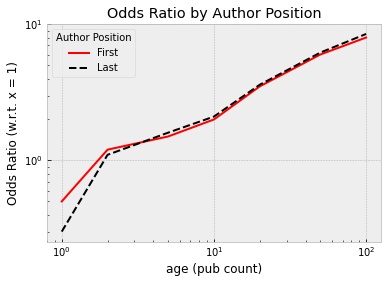

In [465]:
data = {
    'age': np.array([1, 2, 5, 10, 20, 50, 100]),  # Example age in publication count
    'odds_first': np.array([0.5, 1.2, 1.5, 2.0, 3.5, 6.0, 8.0]),  # Example odds ratios for first author
    'odds_last': np.array([0.3, 1.1, 1.6, 2.1, 3.6, 6.2, 8.5])   # Example odds ratios for last author
}


# Create a figure and axis
fig, ax = plt.subplots()

# Plot for First Author position (in red solid line)
ax.plot(data['age'], data['odds_first'], color='red', label='First', linewidth=2)

# Plot for Last Author position (in black dashed line)
ax.plot(data['age'], data['odds_last'], color='black', linestyle='--', label='Last', linewidth=2)

# Set the scale to log on both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Add labels and title
ax.set_xlabel('age (pub count)')
ax.set_ylabel('Odds Ratio (w.r.t. x = 1)')
ax.set_title('Odds Ratio by Author Position')

# Add a legend
ax.legend(title='Author Position')

# Display the plot
plt.show()


In [463]:
ax.axhline(y=1, color='gray', linestyle='-')
ax.grid(True, which="both", ls="--")


from sklearn.linear_model import LogisticRegression

# Assume X is the number of publications (age) and y is the binary outcome (First Author = 1, Last Author = 0)
X = np.log(data['age']).reshape(-1, 1)  # Log-transform of age
y = np.array([1, 0, 1, 1, 0, 0, 1])    # Example outcome

model = LogisticRegression()
model.fit(X, y)

# Calculate odds ratio
odds_ratio = np.exp(model.coef_)


In [464]:
odds_ratio

array([[0.87231737]])

In [466]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Example dataset
data = pd.DataFrame({
    'age': [1, 2, 5, 10, 20, 50, 100],  # Number of publications (academic age)
    'author_position': ['first', 'first', 'middle', 'last', 'middle', 'first', 'last']  # Author position
})

# Convert categorical variable to numeric encoding
data['author_position_encoded'] = data['author_position'].map({'first': 0, 'middle': 1, 'last': 2})

# Prepare X (predictors) and y (target)
X = np.log(data['age']).values.reshape(-1, 1)  # Log-transformed academic age
y = data['author_position_encoded']  # Encoded author position

# Fit multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

# Get predicted probabilities for each author position
predicted_probs = model.predict_proba(X)
print(predicted_probs)  # Probabilities for each class (first, middle, last)


[[0.68732169 0.24494489 0.06773342]
 [0.62036691 0.2751335  0.1044996 ]
 [0.5169673  0.30614226 0.17689044]
 [0.43069262 0.31740529 0.25190208]
 [0.34283258 0.31442375 0.34274367]
 [0.23499602 0.28777901 0.47722498]
 [0.16679874 0.25420138 0.57899987]]


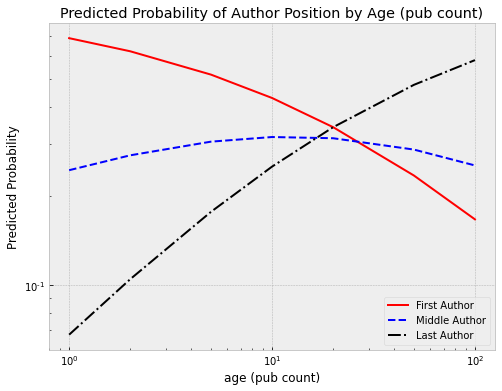

In [472]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Example dataset
data = pd.DataFrame({
    'age': [1, 2, 5, 10, 20, 50, 100],  # Number of publications (academic age)
    'author_position': ['first', 'first', 'middle', 'last', 'middle', 'first', 'last']  # Author position
})

# Convert categorical variable to numeric encoding
data['author_position_encoded'] = data['author_position'].map({'first': 0, 'middle': 1, 'last': 2})

# Prepare X (predictors) and y (target)
X = np.log(data['age']).values.reshape(-1, 1)  # Log-transformed academic age
y = data['author_position_encoded']  # Encoded author position

# Fit multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

# Get predicted probabilities for each author position
predicted_probs = model.predict_proba(X)

# Plot the predicted probabilities
plt.figure(figsize=(8, 6))

# Plot each class (first, middle, last) probabilities
plt.plot(data['age'], predicted_probs[:, 0], label='First Author', color='red', linewidth=2)
plt.plot(data['age'], predicted_probs[:, 1], label='Middle Author', color='blue', linestyle='--', linewidth=2)
plt.plot(data['age'], predicted_probs[:, 2], label='Last Author', color='black', linestyle='-.', linewidth=2)

# Add labels and title
plt.xlabel('age (pub count)')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Author Position by Age (pub count)')

# Set log scale for age
plt.xscale('log')
plt.yscale('log')

# Add legend
plt.legend()

# Show the plot
plt.show()
